In [8]:
import torch
import json
import numpy
from sklearn.preprocessing import MinMaxScaler
import shap
import sys
import time
import pandas as pd
import os
import re

In [9]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [10]:
def load_dataset(path, dataset):
    with open(path + dataset + "_TRAIN.npy", 'rb') as f:
        train = numpy.load(f, allow_pickle=True)
    print("Train shape:", train.shape)
    with open(path + dataset + "_TEST.npy", 'rb') as f:
        test = numpy.load(f, allow_pickle=True)
    print("Test shape:", test.shape)
    #scaling
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train.reshape(-1,train.shape[-1])).reshape(train.shape)
    test = scaler.fit_transform(test.reshape(-1,test.shape[-1])).reshape(test.shape)
    return train, test

In [11]:
def load_cluster_labels(path, cluster_labels):
    print("Silhouette Score:", cluster_labels.split('SilhouetteScore_')[1].split('_')[0])
    cluster_labels = numpy.load(path + cluster_labels)
    print("Number of clusters:", len(set(cluster_labels)))
    print("Clusters:", set(cluster_labels))
    print("Cluster Labels:",cluster_labels)
    return cluster_labels

In [12]:
def get_data_per_cluster(cluster_indices, data, print_=False):
    cluster_data = numpy.array([])
    count = 0
    for i in cluster_indices:
        sample = data[i].reshape(1, data.shape[1])
        # reshape to (x, 1)
        sample = sample.reshape(1, sample.shape[1])
        if print_:
            print(sample.shape)
        if count == 0:
            cluster_data = sample
        else:
            cluster_data = numpy.append(cluster_data, sample, axis=0) 
        count = count + 1
    if print_:
        print(cluster_data.shape)
    return cluster_data

In [13]:
def get_anomaly_cluster_association(cluster_labels, cluster):
    # get position (index) of each anomaly belonging to a cluster
    cluster_indices = [index for index, value in enumerate(cluster_labels) if value == cluster]
    print(len(cluster_indices),"samples in cluster", cluster)
    return cluster_indices

## Features

In [14]:
df = pd.read_csv('/home/sto2/storage_data/df_nonValidatedAnomalies_sigmaGr10_reducedFeatures_sergeValidated.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.drop(['systemid','instanceid'], axis=1, inplace=True)
features = df.columns[2:].to_list()
counter = 0
for feature in features:
    print(counter, feature)
    counter = counter + 1

0 Read Cache Hits - VCC (%)
1 Read Cache Hits - VC (%)
2 Write Cache Hits - VCC (%)
3 Back-end Read I/O Rate (ops/s)
4 Back-end Write Data Rate (MiB/s)
5 Back-end Read Response Time (ms/op)
6 Back-end Write Response Time (ms/op)
7 Overall Back-end Response Time (ms/op)
8 Back-end Read Queue Time (ms/op)
9 Back-end Write Queue Time (ms/op)
10 Overall Back-end Queue Time (ms/op)
11 Back-end Read Transfer Size (KiB/op)
12 Back-end Write Transfer Size (KiB/op)
13 Read I/O Rate - overall (ops/s)
14 Write I/O Rate - overall (ops/s)
15 Total I/O Rate - overall (ops/s)
16 Write Cache Hits - VC (%)
17 Peak Back-end Read Response Time (ms)
18 Port Send Data Rate (MiB/s)
19 Write Data Rate (MiB/s)
20 Total Data Rate (MiB/s)
21 Read Response Time (ms/op)
22 Write Response Time (ms/op)
23 Port Receive Data Rate (MiB/s)
24 Overall Response Time (ms/op)
25 Read Transfer Size (KiB/op)
26 Write Transfer Size (KiB/op)
27 Port Send I/O Rate (ops/s)
28 Port Receive I/O Rate (ops/s)
29 Total Port I/O Rate 

In [15]:
print(len(features))

101


## Paths

In [23]:
data_path = '/home/sto/Data/2-nonValidatedAnomalies_reducedFeatures_sergeValidated_ZERO/'
dataset = '2-nonValidatedAnomalies_reducedFeatures_sergeValidated_ZERO'

In [24]:
shap_values_path = '/home/sto/Data/2-SHAP/FINAL_FINAL_SEPARTED/cluster_responeTime/'

In [25]:
cluster_indices_path = 'nonValidated_respone_time_samples_silhouetteScore_0.8879986216174587.npy'

## Dataset

In [18]:
train, test = load_dataset(data_path, dataset)

Train shape: (740, 101, 5552)
Test shape: (186, 101, 5552)


In [39]:
dataset = numpy.concatenate((train,test))
print(dataset.shape)

(926, 101, 5552)


In [40]:
number_anomalies = dataset.shape[0]
number_anomalies

926

## Shap Values

In [26]:
all_files = os.listdir(shap_values_path)
all_files.sort(key=natural_keys)
shap_values = []
for file in all_files:
    if 'shap-values' in file:
        print(file)
        array = numpy.load(shap_values_path + file)
        shap_values.append(array)
print(len(shap_values))

shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__0Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__30Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__44Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__53Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__54Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__55Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__76Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noResponseTime_Anomaly__95Cluster_.npy
shap-values_all-anomalies_samples-to-explain_752_CLUSTER_background-data_25_noRes

In [27]:
shap_values = numpy.concatenate(shap_values, axis=0 )
print(shap_values.shape)
print(shap_values)

(29, 101, 5552)
[[[-3.88957241e-11 -1.00459471e-11 -2.15538258e-11 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.26841307e-11 -1.53357622e-13 -3.28105330e-14 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.21594750e-16 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-2.11667385e-09 -3.11387121e-09  4.24792213e-13 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-6.57554020e-11  5.25451722e-12  4.96986643e-12 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.92572330e-09 -2.50844382e-09  1.22611934e-12 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 3.27294970e-11  1.15942019e-11  2.39935313e-11 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.32126362e-11 -1.59747524e-13 -3.41776385e-14 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.26661197e-16 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 2.0

In [28]:
number_samples = shap_values.shape[0]
print(number_samples)

29


## Length of Anomalies

In [29]:
cluster_indices = numpy.load(cluster_indices_path)
cluster_indices

array([  0,  30,  44,  53,  54,  55,  76,  95, 130, 142, 143, 145, 161,
       251, 278, 287, 308, 311, 344, 369, 372, 396, 510, 519, 532, 591,
       724, 749, 894])

In [30]:
cluster_indices.shape

(29,)

In [31]:
anomalies_length = numpy.load("/home/sto/Data/2-nonValidatedAnomalies_reducedFeatures_sergeValidated/anomalies_length.npy")
cluster_anomalies_length = []
for i in cluster_indices:
    cluster_anomalies_length.append(anomalies_length[i])
print(len(cluster_anomalies_length))
print(cluster_anomalies_length)

29
[208, 140, 172, 268, 66, 263, 428, 216, 311, 371, 201, 258, 409, 233, 490, 384, 350, 240, 414, 176, 557, 232, 400, 446, 162, 157, 481, 440, 1101]


In [32]:
print(numpy.amin(cluster_anomalies_length))
print(numpy.amax(cluster_anomalies_length))

66
1101


## Cut Shap Values to Lengths of Anomalies

In [33]:
new_shap_values = []
for i in range(0,number_samples):
    feature_array = []
    length = cluster_anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,101):
        print("Dimensions #",x+1)
        print(shap_values[i][x])
        print(shap_values[i][x].shape[0])
        new_anomaly = shap_values[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 5552 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_shap_values.append(feature_array)
    print("#####################################################")
new_shap_values = numpy.array(new_shap_values)

Anomaly # 1 Length: 208
Dimensions # 1
[-3.88957241e-11 -1.00459471e-11 -2.15538258e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
208
Dimensions # 2
[ 1.26841307e-11 -1.53357622e-13 -3.28105330e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
208
Dimensions # 3
[0.0000000e+00 0.0000000e+00 1.2159475e-16 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
5552
208
Dimensions # 4
[8.90794146e-08 5.51689802e-08 3.29967345e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 5
[2.62731768e-10 1.83410149e-10 2.26115280e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 6
[1.76498232e-10 2.79638039e-10 9.91135726e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 7
[-4.54878769e-09 -3.95287335e-09  6.80468792e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
208
Dimensions # 8
[1.64236369e-11 2.53252930e-11 1.73581154e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552


Dimensions # 97
[-9.16513942e-13 -3.97674737e-13 -3.59589616e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
140
Dimensions # 98
[0. 0. 0. ... 0. 0. 0.]
5552
140
Dimensions # 99
[ 2.05247271e-10  1.69556761e-10 -3.19786589e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
140
Dimensions # 100
[ 1.02449870e-12 -4.64848382e-14 -8.86873219e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
140
Dimensions # 101
[-5.24814722e-10 -8.97166301e-11  2.06188069e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
140
#####################################################
Anomaly # 3 Length: 172
Dimensions # 1
[-1.77255943e-11 -3.84136582e-12 -7.28164225e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
172
Dimensions # 2
[ 1.32126362e-11 -1.59747524e-13 -3.41776386e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
172
Dimensions # 3
[0.00000000e+00 0.00000000e+00 1.26661197e-16 ... 0.00000000e+00
 0.00000000e+00 0.0000000

Dimensions # 5
[-9.53988294e-11 -9.89528820e-11 -8.26843495e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
66
Dimensions # 6
[-2.02094987e-10 -1.73353140e-10 -1.32470701e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
66
Dimensions # 7
[-5.80370226e-10  1.96232243e-10  1.02747663e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
66
Dimensions # 8
[ 1.41153187e-12 -8.75814707e-13  1.98864595e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
66
Dimensions # 9
[4.32596927e-15 0.00000000e+00 1.10576334e-15 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
66
Dimensions # 10
[6.10124777e-14 2.61156417e-14 3.66625110e-15 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
66
Dimensions # 11
[2.45088402e-14 6.26066560e-15 1.82751984e-14 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
66
Dimensions # 12
[2.65185778e-11 2.88277612e-11 4.22053439e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
66
Dimensions # 

Dimensions # 11
[2.45088402e-14 6.26066560e-15 1.82751984e-14 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
428
Dimensions # 12
[5.21599308e-12 8.98433599e-12 1.62524196e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
428
Dimensions # 13
[ 1.86465513e-10  4.32751535e-10 -1.60323516e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
428
Dimensions # 14
[-5.59245222e-09 -1.44024763e-08 -8.35538084e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
428
Dimensions # 15
[-4.94169605e-08 -2.46954687e-08 -2.39476810e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
428
Dimensions # 16
[ 3.92027812e-11  5.08638729e-10 -3.96588349e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
428
Dimensions # 17
[8.63434583e-12 6.49368874e-12 1.74825365e-12 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
428
Dimensions # 18
[-2.76574573e-11 -4.16398670e-11 -6.04074174e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
555

5552
311
Dimensions # 8
[-3.32963873e-12 -6.02943527e-12 -3.81984772e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
311
Dimensions # 9
[4.32596927e-15 0.00000000e+00 1.10576334e-15 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
311
Dimensions # 10
[6.10124777e-14 2.61156417e-14 3.66625110e-15 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
311
Dimensions # 11
[2.45088402e-14 6.26066560e-15 1.82751984e-14 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
311
Dimensions # 12
[ 1.16814838e-11 -7.99035972e-12  4.86832925e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
311
Dimensions # 13
[-9.85894155e-10 -9.30863249e-10 -1.28956750e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
311
Dimensions # 14
[-1.11772385e-09 -7.64926645e-09  3.98503095e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
311
Dimensions # 15
[-1.17624304e-07 -4.02788999e-08 -4.25155621e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+

Dimensions # 2
[ 1.32126362e-11 -1.59747524e-13 -3.41776385e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
201
Dimensions # 3
[0.00000000e+00 0.00000000e+00 1.26661197e-16 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
201
Dimensions # 4
[-2.08380570e-07 -1.77796210e-07 -7.59156816e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
201
Dimensions # 5
[1.30911683e-10 1.45728859e-11 7.60794937e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
201
Dimensions # 6
[-1.30852056e-09 -1.25286364e-09 -6.23234512e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
201
Dimensions # 7
[-2.30615642e-09 -1.54472670e-09  3.35999578e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
201
Dimensions # 8
[8.61883121e-12 9.31115655e-12 7.46742952e-12 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
201
Dimensions # 9
[4.32596927e-15 0.00000000e+00 1.10576334e-15 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
201
Dimensio

[1.33603599e-07 1.06275217e-07 1.45405696e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
258
Dimensions # 78
[-3.20988624e-09 -2.60395105e-09 -4.97364966e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
258
Dimensions # 79
[-2.70538922e-09 -1.79390233e-09 -2.76662721e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
258
Dimensions # 80
[ 4.24193204e-11  2.15941110e-11 -2.52493349e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
258
Dimensions # 81
[2.63187088e-08 6.40340466e-09 1.71536864e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
258
Dimensions # 82
[-1.47613678e-10 -2.97589485e-11 -6.10086607e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
258
Dimensions # 83
[-2.61570731e-08 -3.55225663e-08 -1.53662908e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
258
Dimensions # 84
[-4.67570754e-13 -6.41124635e-13 -3.33814574e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
258
Dime

233
Dimensions # 48
[-2.49863566e-14 -6.21293862e-14 -1.63129126e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
233
Dimensions # 49
[-5.49888017e-13 -9.63837549e-13 -1.52000789e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
233
Dimensions # 50
[-3.16762948e-14  4.89068894e-12 -3.19240786e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
233
Dimensions # 51
[7.95606445e-12 7.62980041e-12 3.99986767e-12 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
5552
233
Dimensions # 53
[-1.34537303e-14 -1.64286027e-14 -1.96387109e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
233
Dimensions # 54
[-8.78871964e-15 -5.29682079e-15 -5.91952454e-15 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
233
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
5552
233
Dimensions # 56
[0. 0. 0. ... 0. 0. 0.]
5552
233
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
5552
233
Dimensions # 58
[-1.10884663e-10 -1.68

[8.97331090e-08 1.18042609e-08 1.21837796e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 30
[-1.08192420e-09 -3.48357746e-10 -8.79731342e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
384
Dimensions # 31
[-1.82413985e-11 -5.02808851e-11 -1.96498468e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
384
Dimensions # 32
[1.71226265e-12 5.45614954e-12 5.50516740e-13 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 33
[-2.92243144e-09 -1.36467428e-09 -2.29554157e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
384
Dimensions # 34
[-1.29730670e-10 -2.48615665e-11  1.52939972e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
384
Dimensions # 35
[1.08191946e-05 6.57952387e-06 1.30546859e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 36
[1.44916339e-06 1.22669019e-06 1.71665447e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 37


Dimensions # 11
[2.45088402e-14 6.26066560e-15 1.82751984e-14 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
240
Dimensions # 12
[-2.72831582e-11 -3.08526911e-11 -4.33652724e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
240
Dimensions # 13
[-5.53937058e-10 -4.47744407e-10 -5.84663631e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
240
Dimensions # 14
[2.80698514e-09 3.25490966e-09 3.76454626e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
240
Dimensions # 15
[8.53463033e-08 1.45837674e-08 3.25014295e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
240
Dimensions # 16
[-4.60540931e-11  4.40190694e-12  5.02051879e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
240
Dimensions # 17
[8.65511976e-12 6.50931439e-12 1.75246343e-12 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
240
Dimensions # 18
[ 4.65928251e-12  2.44620885e-11 -6.27010270e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
240


Dimensions # 97
[-1.50863360e-12 -6.58113026e-13 -5.18172605e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
414
Dimensions # 98
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 99
[ 2.42565193e-10  2.22405885e-10 -3.93262018e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
414
Dimensions # 100
[ 1.02449870e-12 -4.64848381e-14 -8.86873219e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
414
Dimensions # 101
[ 7.12894240e-10  3.58860384e-10 -1.76777946e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
414
#####################################################
Anomaly # 20 Length: 176
Dimensions # 1
[-4.08534052e-11 -9.43288472e-12 -1.26855459e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
176
Dimensions # 2
[1.32126362e-11 2.98008662e-12 7.50700031e-14 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
176
Dimensions # 3
[0.00000000e+00 0.00000000e+00 1.26661198e-16 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00

Dimensions # 80
[-5.20713868e-10 -5.97129443e-10 -5.92113149e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
557
Dimensions # 81
[9.19441087e-08 9.20535421e-08 6.13485921e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 82
[-2.12338491e-10 -4.92202560e-11 -8.36877825e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
557
Dimensions # 83
[5.12835678e-08 2.95350216e-08 2.04529144e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 84
[-4.98597502e-13 -7.04152614e-13 -3.76177498e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
557
Dimensions # 85
[1.33333947e-09 1.01483801e-09 9.89990609e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 86
[-3.02266264e-12 -2.55155172e-12 -1.58441236e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
557
Dimensions # 87
[2.61319428e-10 2.07196785e-10 1.88947761e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557


  0.00000000e+00  0.00000000e+00]
5552
400
Dimensions # 75
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 76
[1.10563684e-07 9.43475203e-08 9.53129995e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 77
[1.75892611e-07 1.53600360e-07 1.88544355e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 78
[9.32916666e-09 8.82414256e-09 9.16346687e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 79
[-3.71674658e-09 -2.72935864e-09 -4.28643679e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
400
Dimensions # 80
[ 1.89970760e-11  3.93010198e-11 -2.40111278e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
400
Dimensions # 81
[9.21107424e-08 9.22552617e-08 6.14565220e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 82
[-2.14419196e-10 -4.96107945e-11 -8.51523114e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
400
Dimensions # 83
[5.17881429e-08 2.99

Dimensions # 64
[0. 0. 0. ... 0. 0. 0.]
5552
162
Dimensions # 65
[0. 0. 0. ... 0. 0. 0.]
5552
162
Dimensions # 66
[ 0.00000000e+00  0.00000000e+00 -6.07842982e-16 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
162
Dimensions # 67
[-4.59534348e-14 -1.91015306e-14 -5.65643120e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
162
Dimensions # 68
[-5.14368364e-11 -3.15762352e-11 -3.99545859e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
162
Dimensions # 69
[ 2.22048472e-14 -4.32276311e-10  1.05585870e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
162
Dimensions # 70
[1.98323807e-13 8.10623061e-14 3.79044945e-14 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
Dimensions # 71
[0. 0. 0. ... 0. 0. 0.]
5552
162
Dimensions # 72
[0. 0. 0. ... 0. 0. 0.]
5552
162
Dimensions # 73
[ 0.00000000e+00  0.00000000e+00 -4.94218103e-16 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
162
Dimensions # 74
[-1.48642697e-13 -1.448787

Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
5552
481
Dimensions # 53
[1.57856858e-14 2.68540794e-14 3.35167064e-14 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
481
Dimensions # 54
[-8.43717086e-15 -5.08494796e-15 -5.68274356e-15 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
481
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
5552
481
Dimensions # 56
[0. 0. 0. ... 0. 0. 0.]
5552
481
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
5552
481
Dimensions # 58
[1.58086093e-10 1.10063902e-10 1.06011143e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
481
Dimensions # 59
[-9.03012486e-11 -1.42724856e-11 -3.64355001e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
481
Dimensions # 60
[0. 0. 0. ... 0. 0. 0.]
5552
481
Dimensions # 61
[1.43331622e-11 8.12681786e-12 1.34990765e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
481
Dimensions # 62
[-1.30194161e-10 -2.49203494e-10 -4.84995817e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
481
Dimen

  0.00000000e+00  0.00000000e+00]
5552
1101
Dimensions # 35
[1.20602599e-05 6.96559782e-06 1.35959216e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
1101
Dimensions # 36
[-4.95846611e-06 -3.83394416e-06 -4.55705941e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
1101
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
5552
1101
Dimensions # 38
[ 2.64033418e-10 -2.63757368e-12 -1.02959894e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
1101
Dimensions # 39
[0. 0. 0. ... 0. 0. 0.]
5552
1101
Dimensions # 40
[3.68992166e-12 2.22612472e-12 5.24375581e-13 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
1101
Dimensions # 41
[ 9.53264788e-09 -5.37157486e-11 -6.88424698e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
1101
Dimensions # 42
[-1.51203172e-10 -2.44565379e-10 -2.91601837e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5552
1101
Dimensions # 43
[ 9.22395622e-10 -6.82753948e-12 -2.05546624e-11 ...  0.00000000e+00
  0.00000

In [34]:
print(new_shap_values.shape)
print(new_shap_values)

(29, 101, 5552)
[[[-3.88957241e-11 -1.00459471e-11 -2.15538258e-11 ...             nan
               nan             nan]
  [ 1.26841307e-11 -1.53357622e-13 -3.28105330e-14 ...             nan
               nan             nan]
  [ 0.00000000e+00  0.00000000e+00  1.21594750e-16 ...             nan
               nan             nan]
  ...
  [-2.11667385e-09 -3.11387121e-09  4.24792213e-13 ...             nan
               nan             nan]
  [-6.57554020e-11  5.25451722e-12  4.96986643e-12 ...             nan
               nan             nan]
  [-3.92572330e-09 -2.50844382e-09  1.22611934e-12 ...             nan
               nan             nan]]

 [[ 3.27294970e-11  1.15942019e-11  2.39935313e-11 ...             nan
               nan             nan]
  [ 1.32126362e-11 -1.59747524e-13 -3.41776385e-14 ...             nan
               nan             nan]
  [ 0.00000000e+00  0.00000000e+00  1.26661197e-16 ...             nan
               nan             nan]
  ...
  [ 2.0

In [35]:
anomalies_length_new_array = []
for i in range(0,number_samples):
    for x in range(0,101):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_shap_values[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

29
[208, 140, 172, 268, 66, 263, 428, 216, 311, 371, 201, 258, 409, 233, 490, 384, 350, 240, 414, 176, 557, 232, 400, 446, 162, 157, 481, 440, 1101]


## Get Samples from dataset belonging to the Cluster

In [41]:
cluster_indices

array([  0,  30,  44,  53,  54,  55,  76,  95, 130, 142, 143, 145, 161,
       251, 278, 287, 308, 311, 344, 369, 372, 396, 510, 519, 532, 591,
       724, 749, 894])

In [42]:
print(dataset.shape)
dataset_new_array = []
for i in cluster_indices:
    print(dataset[i].shape)
    dataset_new_array.append(dataset[i])
dataset_new_array = numpy.array(dataset_new_array)
print(dataset_new_array.shape)

(926, 101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(101, 5552)
(29, 101, 5552)


In [43]:
print(dataset_new_array.shape)
print(dataset_new_array)

(29, 101, 5552)
[[[4.83117345e-08 4.38956734e-08 4.48896498e-08 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [1.68751827e-07 1.54326942e-07 1.58800001e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.72231247e-07 1.57508940e-07 1.62074228e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[1.67742796e-07 1.52592752e-07 1.57408455e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [6.08898346e-08 5.56849789e-08 5.72989695e-08 ... 0.0000000

In [44]:
dataset = dataset_new_array

## Cut Samples to Lengths of Anomalies

In [45]:
new_samples = []
for i in range(0,number_samples):
    feature_array = []
    length = cluster_anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,101):
        print("Dimensions #",x+1)
        print(dataset[i][x])
        print(dataset[i][x].shape[0])
        new_anomaly = dataset[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 5552 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_samples.append(feature_array)
    print("#####################################################")
new_samples = numpy.array(new_samples)

Anomaly # 1 Length: 208
Dimensions # 1
[4.83117345e-08 4.38956734e-08 4.48896498e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 2
[0. 0. 0. ... 0. 0. 0.]
5552
208
Dimensions # 3
[1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 4
[5.17981125e-07 4.77315729e-07 4.83488704e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 5
[1.32950344e-06 1.20672531e-06 1.24512298e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 6
[2.28423865e-09 1.93783727e-09 2.16753816e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 7
[9.63451155e-08 8.66585552e-08 8.88625161e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 8
[5.06725204e-08 4.52002929e-08 4.68410890e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
208
Dimensions # 9
[0. 0. 0. ... 0. 0. 0.]
5552
208
Dimensions # 10
[0. 0. 0. ... 0. 

Dimensions # 94
[7.37923906e-06 6.89588460e-06 6.65902429e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
140
Dimensions # 95
[0. 0. 0. ... 0. 0. 0.]
5552
140
Dimensions # 96
[0. 0. 0. ... 0. 0. 0.]
5552
140
Dimensions # 97
[2.15723986e-09 2.60923901e-09 1.70259795e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
140
Dimensions # 98
[1.37437055e-07 1.25688952e-07 1.29331960e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
140
Dimensions # 99
[6.08898346e-08 5.56849789e-08 5.72989695e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
140
Dimensions # 100
[1.39176765e-07 1.27279952e-07 1.30969073e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
140
Dimensions # 101
[9.22046068e-08 7.31859723e-08 7.36701036e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
140
#####################################################
Anomaly # 3 Length: 172
Dimensions # 1
[8.20447029e-08 7.33609823e-08 7.84832170e-08 ... 0.00000000e+00
 0.0000000

Dimensions # 85
[0.00000000e+00 1.98874925e-09 2.78309280e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 86
[1.04382574e-10 7.95499699e-11 9.82268048e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 87
[4.00133199e-10 3.02289886e-10 1.80082475e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 88
[7.13280920e-10 5.25029801e-10 4.58391756e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 89
[6.95883825e-11 6.36399759e-11 6.54845365e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 90
[1.73970956e-09 1.43189946e-08 1.63711341e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 91
[3.47941912e-09 9.54599639e-09 9.82268048e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 92
[1.73970956e-09 9.54599639e-09 9.82268048e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
268
Dimensions # 93
[3.47941

Dimensions # 75
[0. 0. 0. ... 0. 0. 0.]
5552
263
Dimensions # 76
[4.50720474e-06 4.23627455e-06 3.73586007e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
263
Dimensions # 77
[6.50404337e-06 2.16501607e-06 1.80694756e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
263
Dimensions # 78
[6.50404337e-06 2.16501607e-06 1.80694756e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
263
Dimensions # 79
[5.74693917e-06 5.94806262e-06 2.22778393e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
263
Dimensions # 80
[2.27414834e-06 4.86059862e-06 2.06066740e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
263
Dimensions # 81
[3.72231737e-06 4.12192942e-06 4.35906003e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
263
Dimensions # 82
[2.65517953e-06 2.02780828e-06 2.51306732e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
263
Dimensions # 83
[1.03288296e-06 1.11468600e-06 1.32670034e-06 ... 0.00000000e+00
 0.00000000e+00 

Dimensions # 66
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 67
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 68
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 69
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 70
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 71
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 72
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 73
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 74
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 75
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 76
[0. 0. 0. ... 0. 0. 0.]
5552
216
Dimensions # 77
[3.54716341e-06 2.77292103e-06 3.03946476e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
216
Dimensions # 78
[1.16965893e-06 1.04991641e-06 1.15354285e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
216
Dimensions # 79
[5.97097897e-06 5.36500907e-06 5.19624709e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
216
Dimensions # 80
[7.75040610e-08 6.86038941e-08 6.83658561e-08 ... 0.00000000e+00
 0.00000000e+0

[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 61
[8.81510835e-08 7.17063429e-08 7.80248253e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
371
Dimensions # 62
[2.22989013e-07 3.28605016e-07 3.45421108e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
371
Dimensions # 63
[0.00302228 0.         0.00448265 ... 0.         0.         0.        ]
5552
371
Dimensions # 64
[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 65
[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 66
[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 67
[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 68
[1.73796985e-07 1.56792991e-07 1.63318434e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
371
Dimensions # 69
[1.06191872e-07 9.86578727e-08 1.09932166e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
371
Dimensions # 70
[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 71
[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 72
[0. 0. 0. ... 0. 0. 0.]
5552
371
Dimensions # 73
[0. 0. 0. ... 0. 0. 0.]

Dimensions # 33
[9.32484325e-08 8.36706584e-08 8.86005779e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
258
Dimensions # 34
[1.68334297e-07 1.53054142e-07 1.62188826e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
258
Dimensions # 35
[0.0005043  0.00045164 0.0004017  ... 0.         0.         0.        ]
5552
258
Dimensions # 36
[0.00046707 0.00040754 0.0004475  ... 0.         0.         0.        ]
5552
258
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
5552
258
Dimensions # 38
[1.07063466e-06 9.90413035e-07 1.11376100e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
258
Dimensions # 39
[0. 0. 0. ... 0. 0. 0.]
5552
258
Dimensions # 40
[1.73970956e-08 1.59099940e-08 1.63711341e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
258
Dimensions # 41
[4.06222183e-06 3.71498359e-06 3.82139924e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
258
Dimensions # 42
[4.06222183e-06 3.71229481e-06 3.82265982e-06 ... 0.00000000e+00
 0.00000000e+00 0

Dimensions # 19
[4.33187681e-09 9.89601626e-09 7.31789696e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 20
[1.73970956e-11 1.59099940e-11 8.18556707e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 21
[4.33187681e-09 9.91192625e-09 7.39975263e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 22
[5.42789383e-09 3.78657857e-09 1.22783506e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 23
[0.00000000e+00 4.29569838e-10 2.61938146e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 24
[1.73970956e-11 1.59099940e-11 8.18556707e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 25
[4.61023034e-09 3.75475858e-09 1.16235052e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 26
[8.94422959e-07 7.38764661e-08 4.46064292e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
233
Dimensions # 27
[1.66368

Dimensions # 17
[1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 18
[9.30309688e-08 1.41236199e-07 1.09552355e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 19
[3.06188883e-09 9.38689645e-10 2.86494847e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 20
[1.78147999e-06 1.61938283e-06 1.66569741e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 21
[1.78452448e-06 1.62032152e-06 1.66856236e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 22
[6.71527891e-09 1.47962944e-09 6.51571139e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 23
[1.28912479e-08 1.12801857e-08 1.16071341e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 24
[1.18474221e-08 9.67327634e-09 1.34079589e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
384
Dimensions # 25
[1.28390

 0.00000000e+00 0.00000000e+00]
5552
350
Dimensions # 99
[5.91501251e-08 5.40939795e-08 5.56618561e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
350
Dimensions # 100
[1.39176765e-07 1.27279952e-07 1.30969073e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
350
Dimensions # 101
[6.08898346e-08 5.56849789e-08 5.72989695e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
350
#####################################################
Anomaly # 18 Length: 240
Dimensions # 1
[1.28842890e-07 1.12276828e-07 1.15236413e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
240
Dimensions # 2
[0. 0. 0. ... 0. 0. 0.]
5552
240
Dimensions # 3
[1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
240
Dimensions # 4
[1.37162181e-06 1.23520420e-06 1.53805168e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
240
Dimensions # 5
[9.04822943e-07 8.72504070e-07 9.11200955e-07 ... 0.00000000e+00
 0.00000000e+00 0.000

Dimensions # 65
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 66
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 67
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 68
[1.32705045e-07 1.25545763e-07 1.54314310e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
414
Dimensions # 69
[2.95750625e-10 3.50019868e-10 4.58391756e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
414
Dimensions # 70
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 71
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 72
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 73
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 74
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 75
[0. 0. 0. ... 0. 0. 0.]
5552
414
Dimensions # 76
[1.30304246e-08 1.34439449e-08 1.41610310e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
414
Dimensions # 77
[3.44794778e-06 3.17111636e-06 3.33689553e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
414
Dimensions # 78
[7.01087296e-06 6.42948313e-06 6.67857143e-06 ... 0.000

[5.21912868e-11 4.77299819e-11 4.91134024e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 44
[0. 0. 0. ... 0. 0. 0.]
5552
557
Dimensions # 45
[0. 0. 0. ... 0. 0. 0.]
5552
557
Dimensions # 46
[0. 0. 0. ... 0. 0. 0.]
5552
557
Dimensions # 47
[0. 0. 0. ... 0. 0. 0.]
5552
557
Dimensions # 48
[6.95883825e-10 1.41598946e-09 3.30696910e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 49
[1.57443715e-08 3.30132375e-08 7.72390108e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 50
[1.64402554e-08 3.44292270e-08 8.05459799e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 51
[1.21779669e-10 1.11369958e-10 1.14597939e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
5552
557
Dimensions # 53
[1.73970956e-11 1.59099940e-11 1.63711341e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
557
Dimensions # 54
[1.73970956e-11 1.59099

Dimensions # 20
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 21
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 23
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 24
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 26
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 27
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 28
[8.69854781e-09 7.93908700e-09 8.16919593e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 29
[8.69854781e-09 7.93908700e-09 8.16919593e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 30
[1.73970956e-08 1.58940840e-08 1.63383919e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 31
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 32
[1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
400
Dimensions # 33
[0. 0. 0. ... 0. 0. 0.]
5552
400
Dimensions # 34
[1.739

Dimensions # 8
[4.83639258e-10 4.59798826e-10 4.66577323e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
Dimensions # 9
[0. 0. 0. ... 0. 0. 0.]
5552
162
Dimensions # 10
[0. 0. 0. ... 0. 0. 0.]
5552
162
Dimensions # 11
[0. 0. 0. ... 0. 0. 0.]
5552
162
Dimensions # 12
[2.01875898e-08 2.37218010e-08 4.14075096e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
Dimensions # 13
[2.44585767e-08 2.32540472e-08 7.27205778e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
Dimensions # 14
[2.80945697e-07 3.24516147e-07 3.33021611e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
Dimensions # 15
[1.37791956e-06 1.42267166e-06 1.53864104e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
Dimensions # 16
[1.65886526e-06 1.74718781e-06 1.87166265e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
Dimensions # 17
[1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
162
D

Dimensions # 97
[1.73970956e-10 1.27279952e-10 4.91134024e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
157
Dimensions # 98
[1.37437055e-07 1.25688952e-07 1.29331960e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
157
Dimensions # 99
[7.30678016e-08 8.75049669e-08 8.51298975e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
157
Dimensions # 100
[1.39176765e-07 1.27279952e-07 1.30969073e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
157
Dimensions # 101
[1.13081121e-07 1.03414961e-07 1.03138145e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
157
#####################################################
Anomaly # 27 Length: 481
Dimensions # 1
[1.60383824e-07 1.47899304e-07 1.55083754e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
481
Dimensions # 2
[0. 0. 0. ... 0. 0. 0.]
5552
481
Dimensions # 3
[1.73970956e-07 1.59099940e-07 1.63711341e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
481
Dimensions # 4
[8.1

[0. 0. 0. ... 0. 0. 0.]
5552
440
Dimensions # 74
[0. 0. 0. ... 0. 0. 0.]
5552
440
Dimensions # 75
[0. 0. 0. ... 0. 0. 0.]
5552
440
Dimensions # 76
[1.26857724e-06 1.41196176e-06 1.33547605e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
440
Dimensions # 77
[6.02536891e-06 6.04187845e-06 6.60521285e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
440
Dimensions # 78
[6.75661984e-06 6.91564322e-06 7.36783932e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
440
Dimensions # 79
[7.12583651e-06 5.65575703e-06 5.86184921e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
440
Dimensions # 80
[9.05050978e-07 7.10876772e-07 8.15652371e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
440
Dimensions # 81
[1.01490343e-07 8.27038527e-08 8.07522543e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
440
Dimensions # 82
[1.38623665e-06 8.62154972e-07 9.90929053e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
5552
440
Dimensions # 83

In [46]:
anomalies_length_new_array = []
for i in range(0,number_samples):
    for x in range(0,101):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_samples[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

29
[208, 140, 172, 268, 66, 263, 428, 216, 311, 371, 201, 258, 409, 233, 490, 384, 350, 240, 414, 176, 557, 232, 400, 446, 162, 157, 481, 440, 1101]


In [47]:
###############################################
dataset = new_samples
shap_values = new_shap_values
###############################################

## Weighted down: Zero Buffer Credit Timer

In [48]:
features[62]

'Zero Buffer Credit Timer (µs)'

In [49]:
for i in range(0,23):
    shap_values[i][62] = shap_values[i][62]/100

# Feature Explanations

In [50]:
shap_values_allTimesteps = numpy.nanmean(shap_values, axis=2)
print(shap_values_allTimesteps.shape)
print(shap_values_allTimesteps)

(29, 101)
[[-3.16555984e-12 -3.02021576e-13 -1.68351190e-12 ... -7.85551718e-11
   1.38799878e-11 -1.22890205e-11]
 [ 4.24250878e-12 -3.35799651e-13 -2.44941879e-13 ...  9.34725535e-12
  -2.06831044e-13 -2.03485720e-12]
 [-8.63753071e-13 -3.05646325e-13 -8.06296706e-13 ...  1.03297321e-11
  -1.87254752e-13  3.16815591e-12]
 ...
 [ 5.61652568e-13 -2.23373009e-13 -6.71394458e-11 ...  4.79810561e-12
   2.90132100e-11  4.16690159e-12]
 [-3.51049011e-12  3.28132525e-13 -7.21510246e-10 ... -7.54710218e-12
   3.27496053e-10  1.93079015e-11]
 [-4.78117015e-11 -1.48847102e-13 -4.32936166e-09 ... -3.94255746e-10
   2.24087027e-09  8.69494353e-10]]


In [51]:
samples_allTimesteps = numpy.nanmean(dataset, axis=2)
print(samples_allTimesteps.shape)
print(samples_allTimesteps)

(29, 101)
[[6.99845021e-09 0.00000000e+00 2.30977712e-07 ... 2.24847794e-07
  2.28667935e-07 2.30977712e-07]
 [2.36786183e-07 0.00000000e+00 2.44354776e-07 ... 9.09266710e-08
  1.95483821e-07 1.30131435e-07]
 [1.22571000e-07 0.00000000e+00 2.26345331e-07 ... 7.69574126e-08
  1.81076265e-07 7.92208660e-08]
 ...
 [2.75456085e-07 0.00000000e+00 3.65121999e-07 ... 1.17633432e-07
  2.92097599e-07 1.36844660e-07]
 [7.83601675e-07 9.07446021e-09 1.44140138e-06 ... 2.66370079e-07
  1.17681908e-06 2.80356940e-07]
 [3.40396608e-06 4.99678632e-10 7.33573882e-06 ... 5.30000415e-06
  6.77388696e-06 5.63325152e-06]]


In [52]:
cluster_indices

array([  0,  30,  44,  53,  54,  55,  76,  95, 130, 142, 143, 145, 161,
       251, 278, 287, 308, 311, 344, 369, 372, 396, 510, 519, 532, 591,
       724, 749, 894])

In [53]:
cluster_indices_to_cluster_data = []
for i in range(0,number_samples):
    cluster_indices_to_cluster_data.append(i)
print(cluster_indices_to_cluster_data)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [54]:
cluster_shap_values = get_data_per_cluster(cluster_indices_to_cluster_data, shap_values_allTimesteps)
cluster_sample_values = get_data_per_cluster(cluster_indices_to_cluster_data, samples_allTimesteps)

In [55]:
average_cluster_shap_values = cluster_shap_values.mean(axis=0)
average_cluster_sample_values = cluster_sample_values.mean(axis=0)

In [56]:
average_cluster_shap_values = average_cluster_shap_values.reshape(1,average_cluster_shap_values.shape[0])
average_cluster_sample_values = average_cluster_sample_values.reshape(1,average_cluster_sample_values.shape[0])

## Cluster Plot Top 20

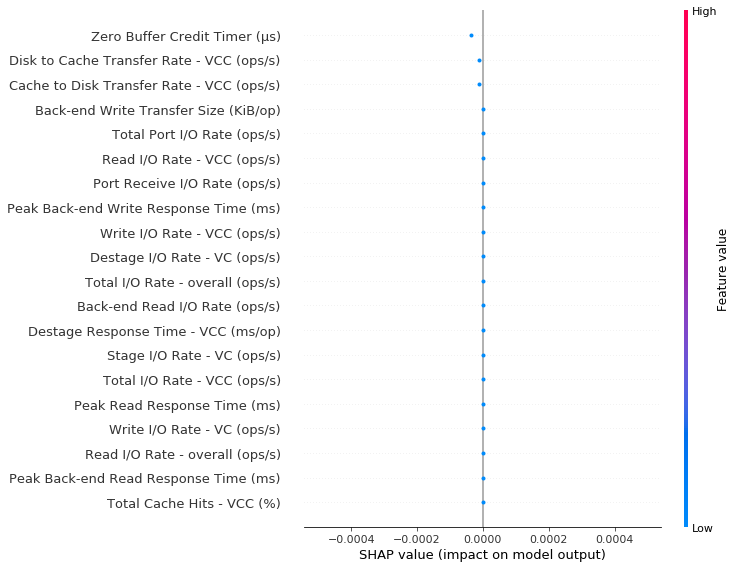

In [57]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features, max_display=20)

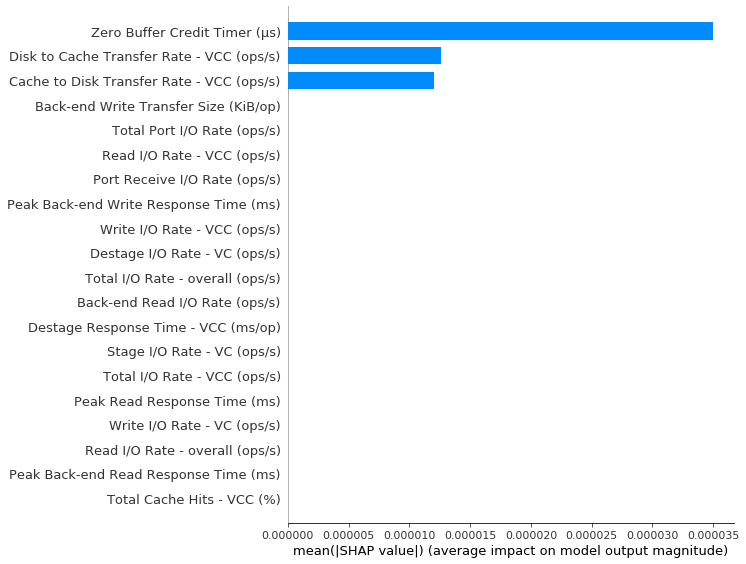

In [58]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features, max_display=20, plot_type='bar')

## Cluster Plot Top 50

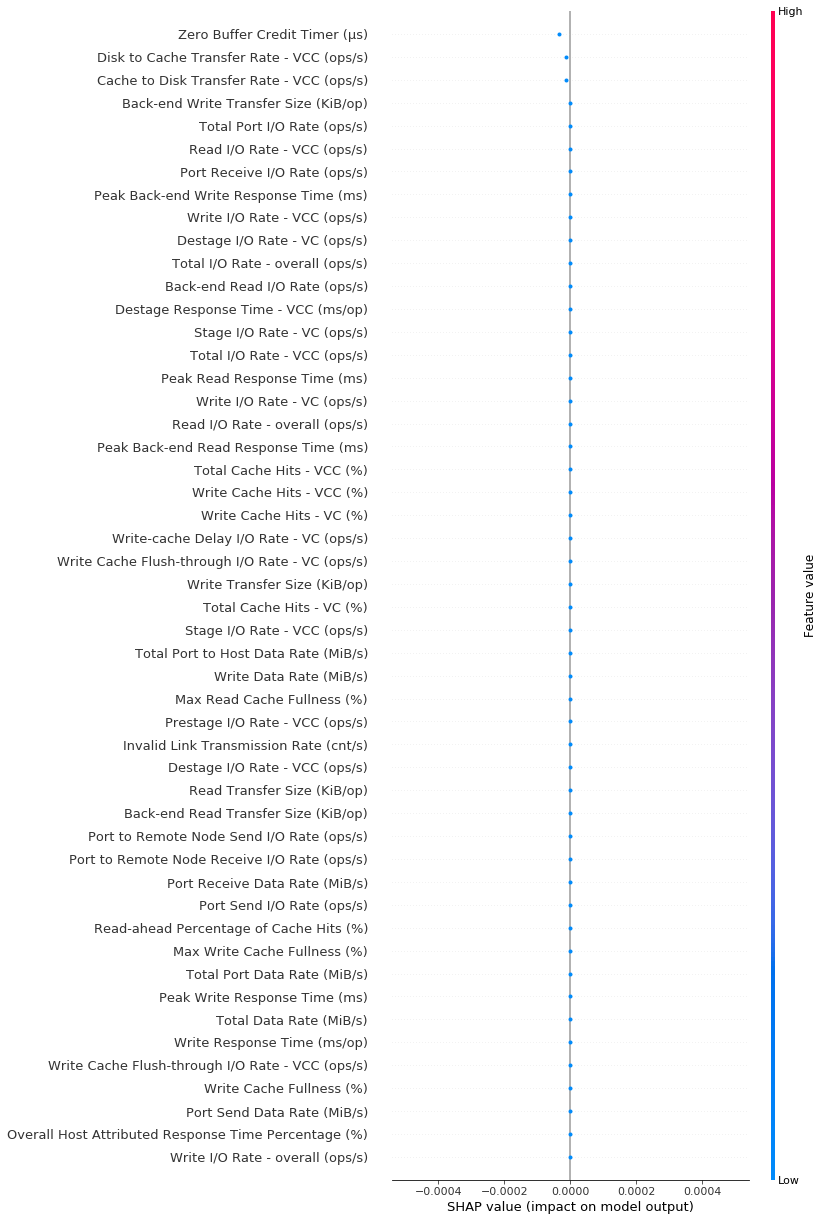

In [59]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features, max_display=50)

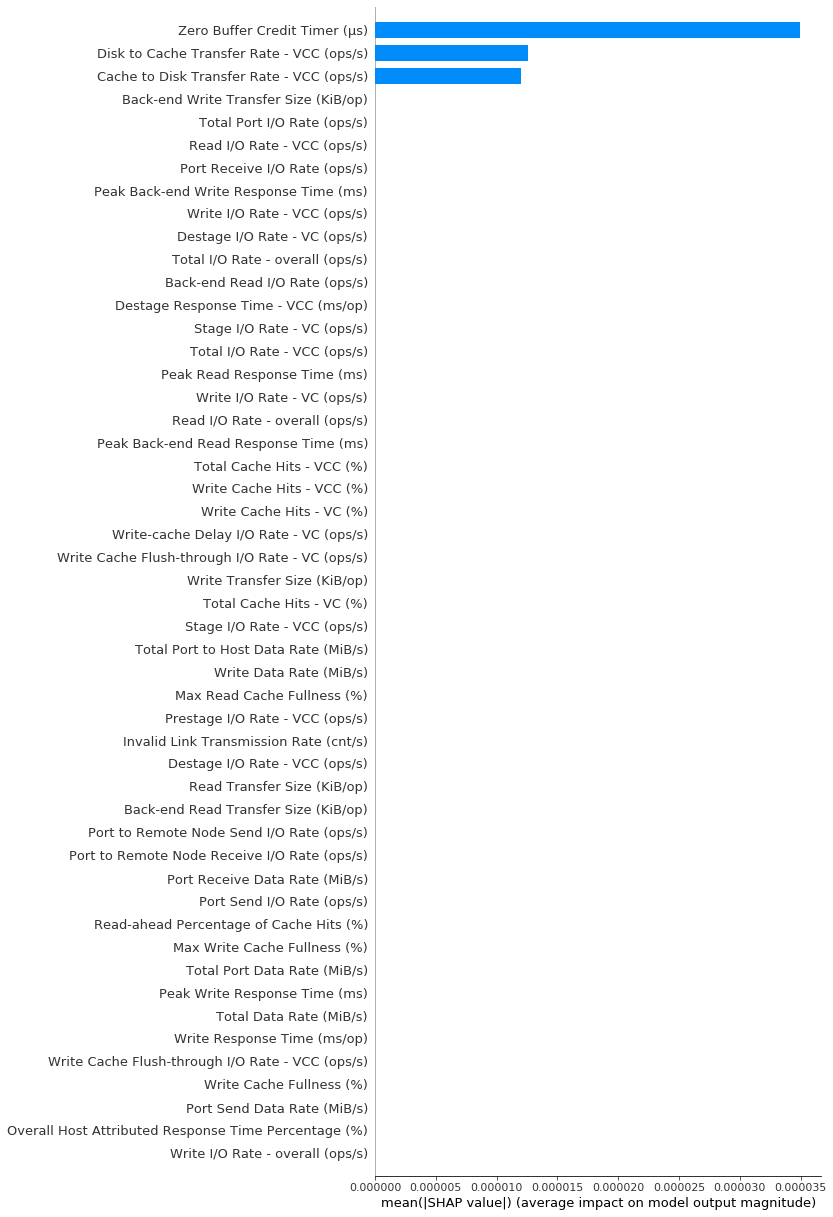

In [60]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features, max_display=50,plot_type='bar')

## Check Top5 Features per Sample

In [61]:
i_o_rates = []
for feature in features:
    if 'I/O' in feature:
        i_o_rates.append(feature)

response_rates = []
for feature in features:
    if 'Response' in feature:
        response_rates.append(feature)

In [62]:
cluster_indices

array([  0,  30,  44,  53,  54,  55,  76,  95, 130, 142, 143, 145, 161,
       251, 278, 287, 308, 311, 344, 369, 372, 396, 510, 519, 532, 591,
       724, 749, 894])

In [63]:
print(cluster_indices_to_cluster_data)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [64]:
def get_reponse_time_samples(cluster_indices, shap_values, features, i_o_rates, response_rates, _print=True):
    reponse_time_samples = []
    for i in cluster_indices:
        #print("Sample", i)
        vals = shap_values_sample = shap_values[i].reshape(1, shap_values.shape[1])
        feature_importance = pd.DataFrame(list(zip(features, sum(vals))), columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=True,inplace=True)
        top = feature_importance.head(4)
        top_features = top.col_name
        if _print:
            print(top_features)
            print("")
        top_features = top_features.tolist()
        io = any(item in i_o_rates for item in top_features)
        response = any(item in response_rates for item in top_features)
        if io:
            print(top)
            print("Sample",i,":IO Rate in Top 5 Feature Importance")
        if response:
            print(top)
            print("Sample",i,":Response Time in Top 5 Feature Importance")
            reponse_time_samples.append(i)
#        if io and response:
#            print("Sample",i,":IO Rate in Top 4 Feature Importance")
    return reponse_time_samples

In [65]:
get_reponse_time_samples(cluster_indices_to_cluster_data, shap_values_allTimesteps, features, i_o_rates, response_rates, _print=False)

                                     col_name  feature_importance_vals
34  Disk to Cache Transfer Rate - VCC (ops/s)            -5.451119e-06
62              Zero Buffer Credit Timer (µs)            -3.998549e-06
35  Cache to Disk Transfer Rate - VCC (ops/s)            -2.903600e-06
77               Write I/O Rate - VCC (ops/s)            -4.062303e-09
Sample 0 :IO Rate in Top 5 Feature Importance
                                     col_name  feature_importance_vals
35  Cache to Disk Transfer Rate - VCC (ops/s)            -1.719376e-05
34  Disk to Cache Transfer Rate - VCC (ops/s)            -6.203052e-06
62              Zero Buffer Credit Timer (µs)            -1.134387e-06
75                Read I/O Rate - VCC (ops/s)            -1.731800e-08
Sample 1 :IO Rate in Top 5 Feature Importance
                                     col_name  feature_importance_vals
35  Cache to Disk Transfer Rate - VCC (ops/s)            -1.833040e-05
34  Disk to Cache Transfer Rate - VCC (ops/s)           

[28]

# Zero Credit Timer weighted down more

In [66]:
features[62]

'Zero Buffer Credit Timer (µs)'

In [67]:
for i in range(0,number_samples):
    shap_values[i][62] = shap_values[i][62]/100

In [68]:
shap_values_allTimesteps = numpy.nanmean(shap_values, axis=2)
print(shap_values_allTimesteps.shape)
print(shap_values_allTimesteps)

(29, 101)
[[-3.16555984e-12 -3.02021576e-13 -1.68351190e-12 ... -7.85551718e-11
   1.38799878e-11 -1.22890205e-11]
 [ 4.24250878e-12 -3.35799651e-13 -2.44941879e-13 ...  9.34725535e-12
  -2.06831044e-13 -2.03485720e-12]
 [-8.63753071e-13 -3.05646325e-13 -8.06296706e-13 ...  1.03297321e-11
  -1.87254752e-13  3.16815591e-12]
 ...
 [ 5.61652568e-13 -2.23373009e-13 -6.71394458e-11 ...  4.79810561e-12
   2.90132100e-11  4.16690159e-12]
 [-3.51049011e-12  3.28132525e-13 -7.21510246e-10 ... -7.54710218e-12
   3.27496053e-10  1.93079015e-11]
 [-4.78117015e-11 -1.48847102e-13 -4.32936166e-09 ... -3.94255746e-10
   2.24087027e-09  8.69494353e-10]]


In [69]:
samples_allTimesteps = numpy.nanmean(dataset, axis=2)
print(samples_allTimesteps.shape)
print(samples_allTimesteps)

(29, 101)
[[6.99845021e-09 0.00000000e+00 2.30977712e-07 ... 2.24847794e-07
  2.28667935e-07 2.30977712e-07]
 [2.36786183e-07 0.00000000e+00 2.44354776e-07 ... 9.09266710e-08
  1.95483821e-07 1.30131435e-07]
 [1.22571000e-07 0.00000000e+00 2.26345331e-07 ... 7.69574126e-08
  1.81076265e-07 7.92208660e-08]
 ...
 [2.75456085e-07 0.00000000e+00 3.65121999e-07 ... 1.17633432e-07
  2.92097599e-07 1.36844660e-07]
 [7.83601675e-07 9.07446021e-09 1.44140138e-06 ... 2.66370079e-07
  1.17681908e-06 2.80356940e-07]
 [3.40396608e-06 4.99678632e-10 7.33573882e-06 ... 5.30000415e-06
  6.77388696e-06 5.63325152e-06]]


In [48]:
cluster_shap_values = get_data_per_cluster(cluster_indices_to_cluster_data, shap_values_allTimesteps)
cluster_sample_values = get_data_per_cluster(cluster_indices_to_cluster_data, samples_allTimesteps)

In [49]:
average_cluster_shap_values = cluster_shap_values.mean(axis=0)
average_cluster_sample_values = cluster_sample_values.mean(axis=0)

In [50]:
average_cluster_shap_values = average_cluster_shap_values.reshape(1,average_cluster_shap_values.shape[0])
average_cluster_sample_values = average_cluster_sample_values.reshape(1,average_cluster_sample_values.shape[0])

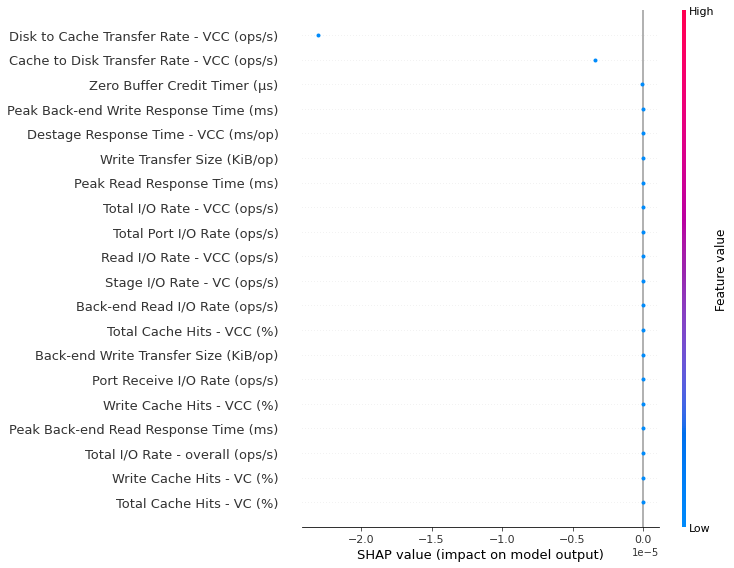

In [51]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features, max_display=20)

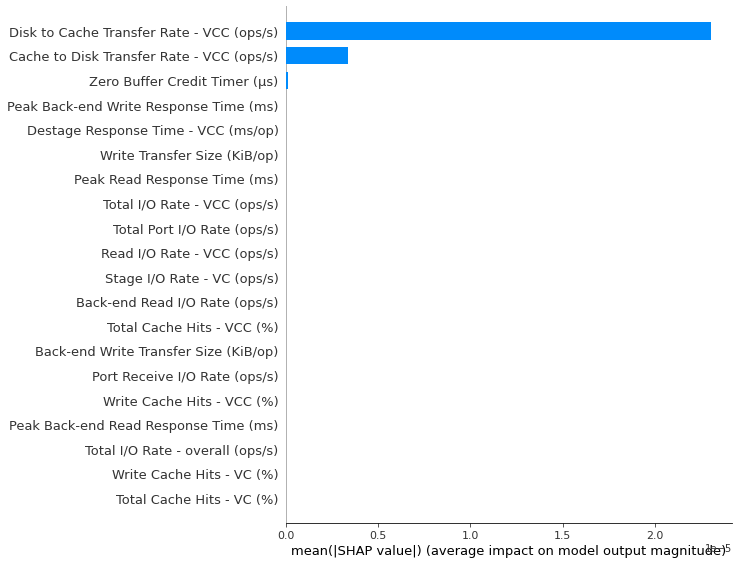

In [52]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features, max_display=20, plot_type='bar')

# Temporal Explanations

In [70]:
shap_values_allFeatures = numpy.nanmean(shap_values, axis=1)
print(shap_values_allFeatures.shape)
print(shap_values_allFeatures)

(29, 5552)
[[ 9.91017019e-09  6.60396559e-09  6.71033451e-08 ...             nan
              nan             nan]
 [-2.94433329e-07 -1.85898445e-07 -1.29714181e-07 ...             nan
              nan             nan]
 [-1.04456840e-07 -6.08719072e-08 -2.32764069e-09 ...             nan
              nan             nan]
 ...
 [-1.34421005e-06 -7.29649865e-07 -6.75733593e-07 ...             nan
              nan             nan]
 [ 4.36244285e-08  4.71224917e-09  7.04341624e-08 ...             nan
              nan             nan]
 [ 8.37053003e-08  3.29263430e-08  9.60030899e-08 ...             nan
              nan             nan]]


Mean of empty slice


## Categories

In [71]:
i_o_rates = []
for feature in features:
    if 'I/O' in feature:
        i_o_rates.append(feature)
        
response_rates = []
for feature in features:
    if 'Response' in feature:
        response_rates.append(feature)

cache = []
for feature in features:
    if 'Cache' in feature:
        cache.append(feature)
    if 'Write-cache Delay Percentage - VCC (%)' == feature or 'Write-cache Delay Percentage - VC (%)' == feature or 'Write-cache Delay Percentage (%)' == feature:
        cache.append(feature)
cache.remove('Cache to Host Transfer Response Time (ms/op)')

data_rates = []
for feature in features:
    if 'Data Rate' in feature:
        data_rates.append(feature)

transfer = []
for feature in features:
    if 'Transfer' in feature:
        transfer.append(feature)

used_categories = i_o_rates + response_rates + cache + data_rates + transfer
other = [x for x in features if x not in used_categories]

In [72]:
other

['Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Overall Back-end Queue Time (ms/op)',
 'Port to Local Node Send Queue Time (ms/op)',
 'Port to Local Node Receive Queue Time (ms/op)',
 'Global Mirror Overlapping Write Percentage (%)',
 'Global Mirror Secondary Write Lag (ms/op)',
 'Zero Buffer Credit Timer (µs)',
 'System CPU Utilization Core 1 (%)',
 'System CPU Utilization Core 2 (%)',
 'System CPU Utilization Core 3 (%)',
 'System CPU Utilization Core 4 (%)',
 'Invalid Link Transmission Rate (cnt/s)',
 'Port Send Delay Time (ms/op)']

In [73]:
def get_position_category_features(category_features, all_features_list):
    indices = []
    for feature in category_features:
        indices.append(all_features_list.index(feature))
    print(len(indices), indices)
    return indices

In [74]:
def get_samples_per_featureCategory(category_positions, dataset):
    category_data = []
    for x in dataset:
        anomaly = []
        for i in category_positions:
            anomaly.append(x[i])
        category_data.append(anomaly)
    category_data = numpy.array(category_data)
    print(category_data.shape)
    # average over features
    category_data = numpy.nanmean(category_data, axis=1)
    print(category_data.shape)
    return category_data

## Averaged over Feature categories: IO Rates, Response Time, Cache, Data Rates, Transfer, Others

In [75]:
position_io_rates = get_position_category_features(i_o_rates, features)
positions_response_rate = get_position_category_features(response_rates, features)
positions_cache = get_position_category_features(cache, features)
positions_data_rates = get_position_category_features(data_rates, features)
positions_transfer = get_position_category_features(transfer, features)
positions_other = get_position_category_features(other, features)

29 [3, 13, 14, 15, 27, 28, 29, 36, 37, 38, 39, 40, 41, 54, 56, 65, 66, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 93, 96]
19 [5, 6, 7, 17, 21, 22, 24, 50, 51, 57, 58, 60, 61, 83, 84, 85, 86, 87, 88]
23 [0, 1, 2, 16, 31, 32, 33, 34, 35, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 97, 98, 99, 100]
14 [4, 18, 19, 20, 23, 30, 42, 43, 44, 45, 46, 47, 48, 49]
7 [11, 12, 25, 26, 34, 35, 88]
14 [8, 9, 10, 52, 53, 55, 59, 62, 89, 90, 91, 92, 94, 95]


In [76]:
io_rate_data = get_samples_per_featureCategory(position_io_rates, dataset)
response_rate_data = get_samples_per_featureCategory(positions_response_rate, dataset)
cache_data = get_samples_per_featureCategory(positions_cache, dataset)
data_rates_data = get_samples_per_featureCategory(positions_data_rates, dataset)
transfer_data = get_samples_per_featureCategory(positions_transfer, dataset)
other_data = get_samples_per_featureCategory(positions_other, dataset)

(29, 29, 5552)
(29, 5552)
(29, 19, 5552)
(29, 5552)
(29, 23, 5552)
(29, 5552)
(29, 14, 5552)
(29, 5552)
(29, 7, 5552)
(29, 5552)
(29, 14, 5552)
(29, 5552)


Mean of empty slice


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


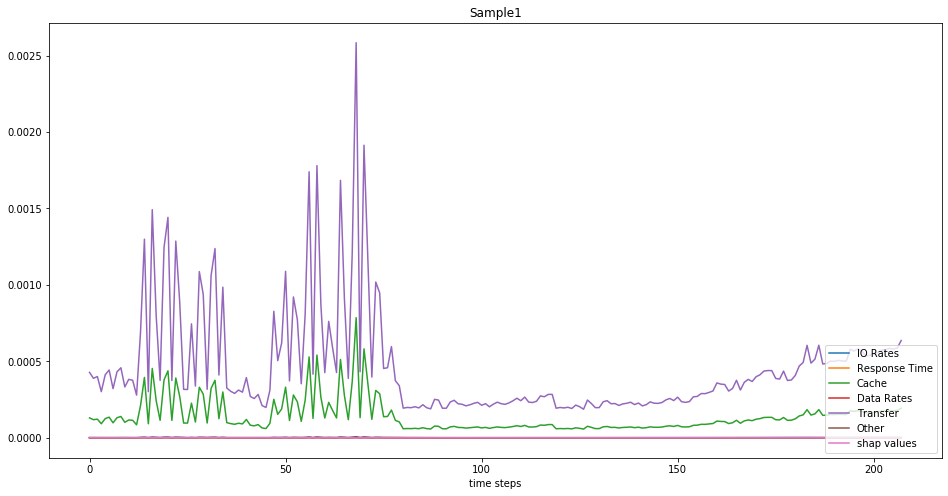

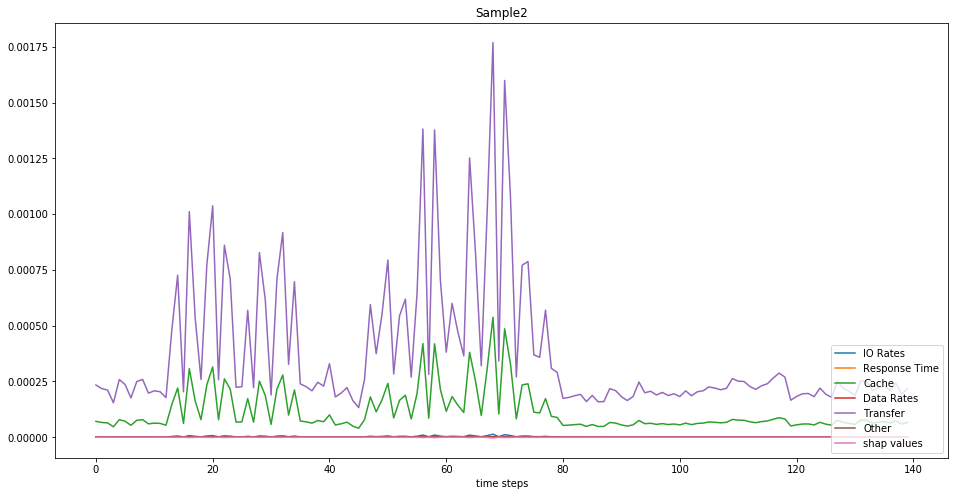

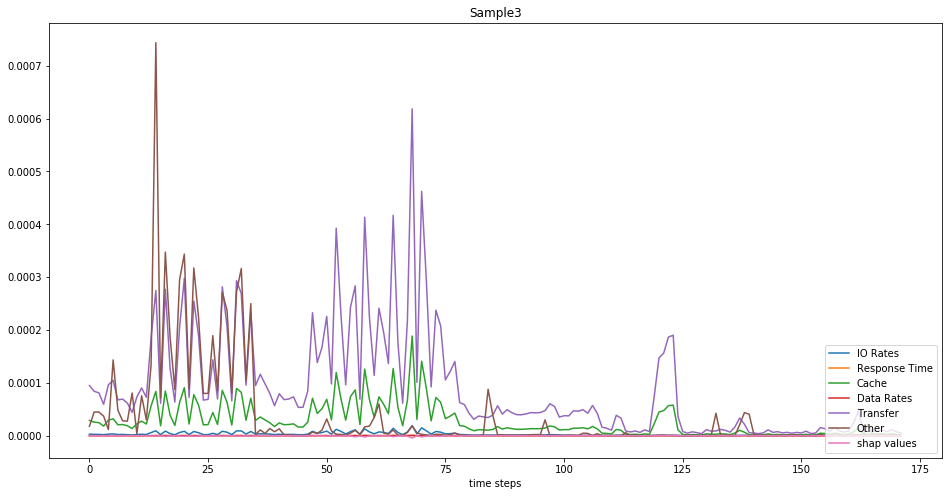

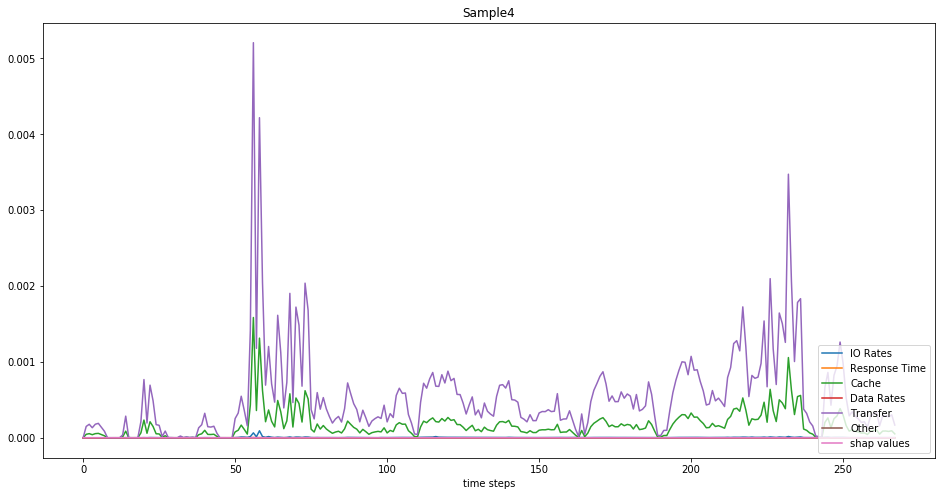

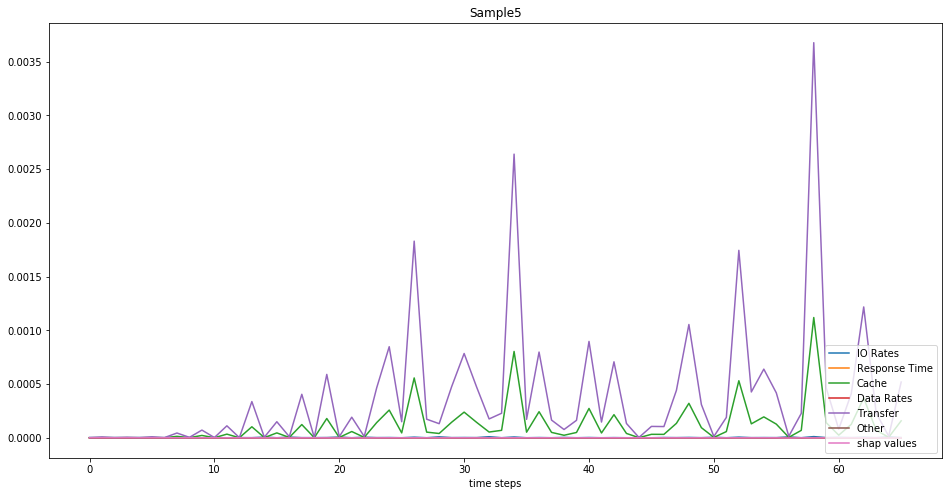

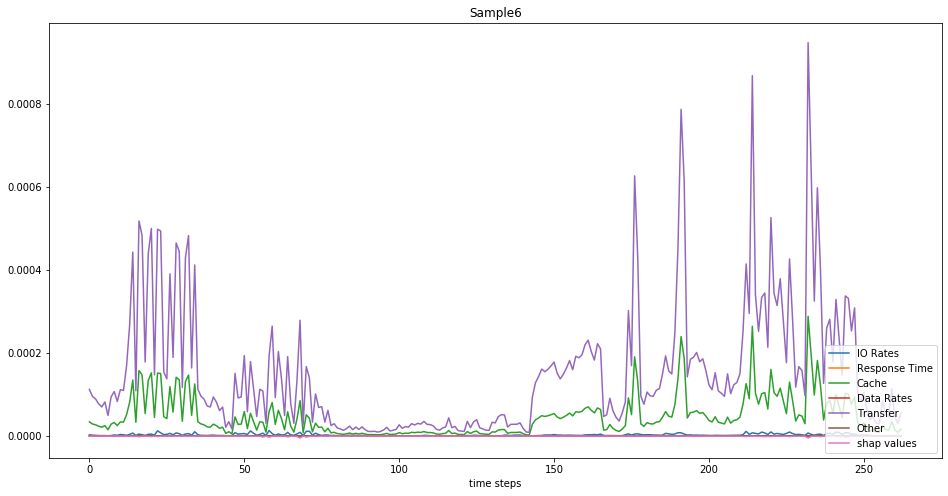

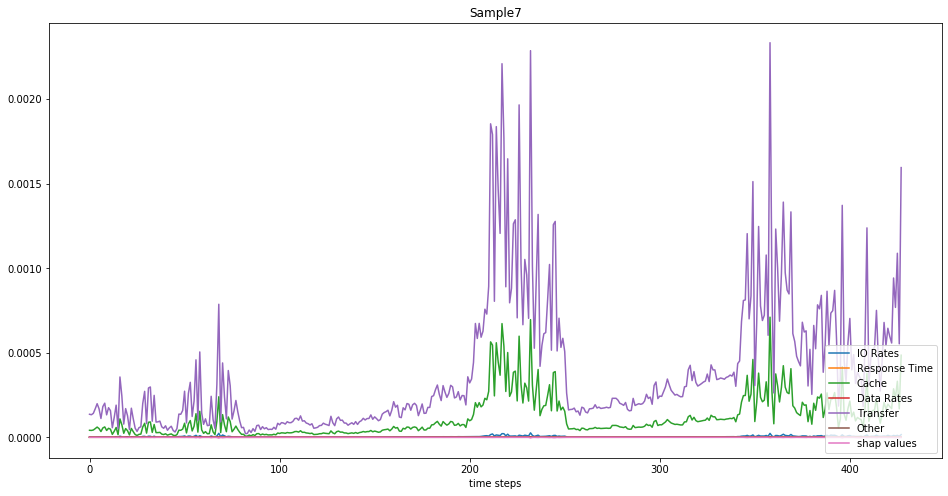

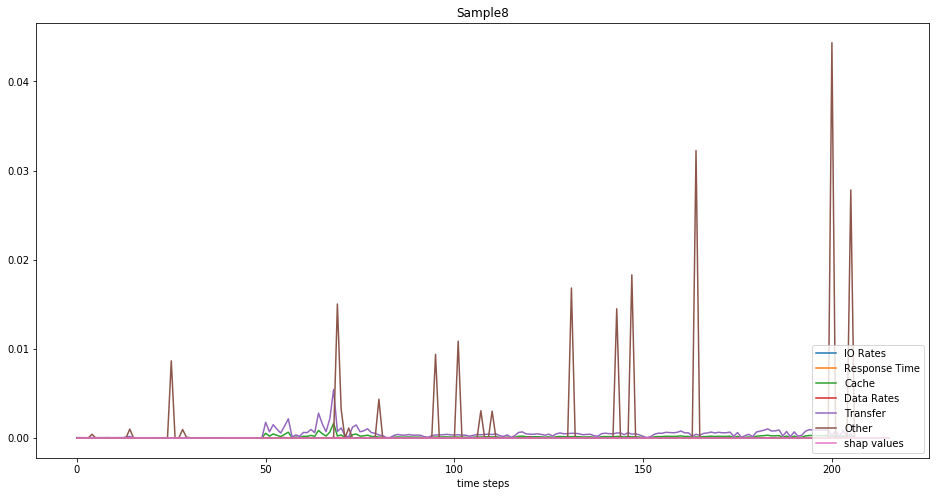

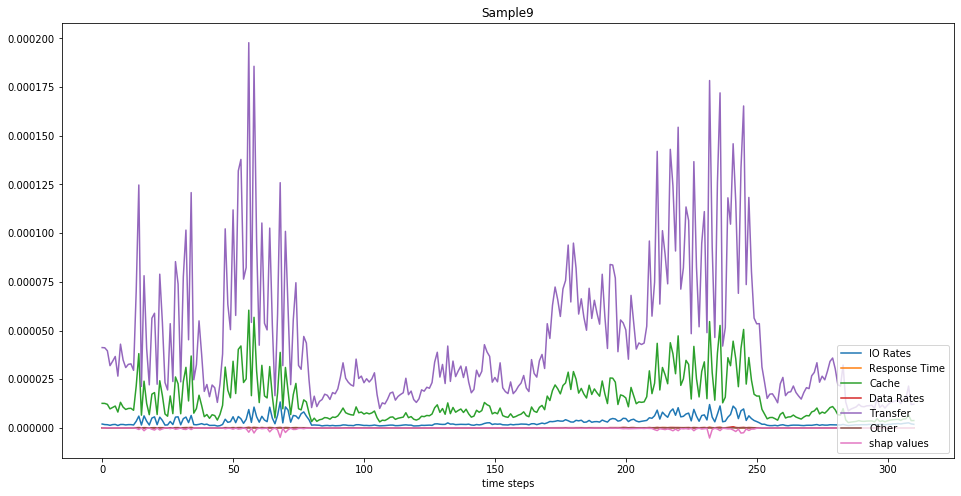

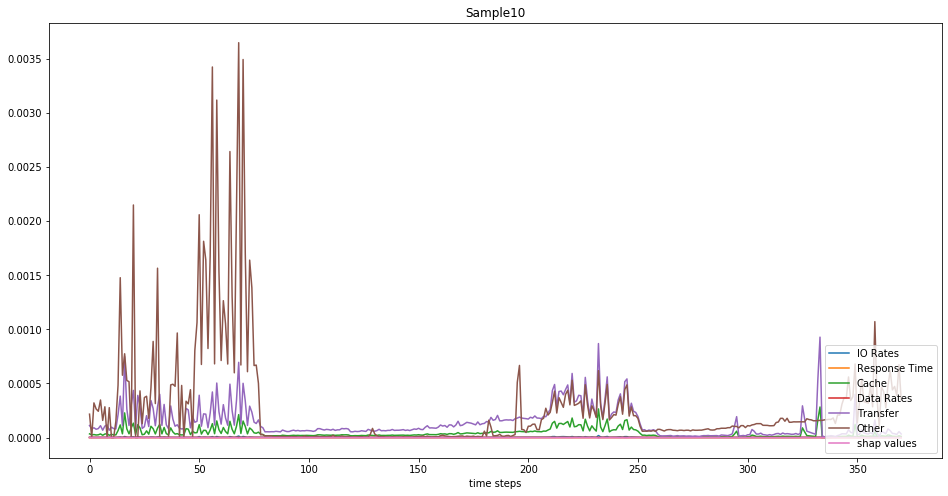

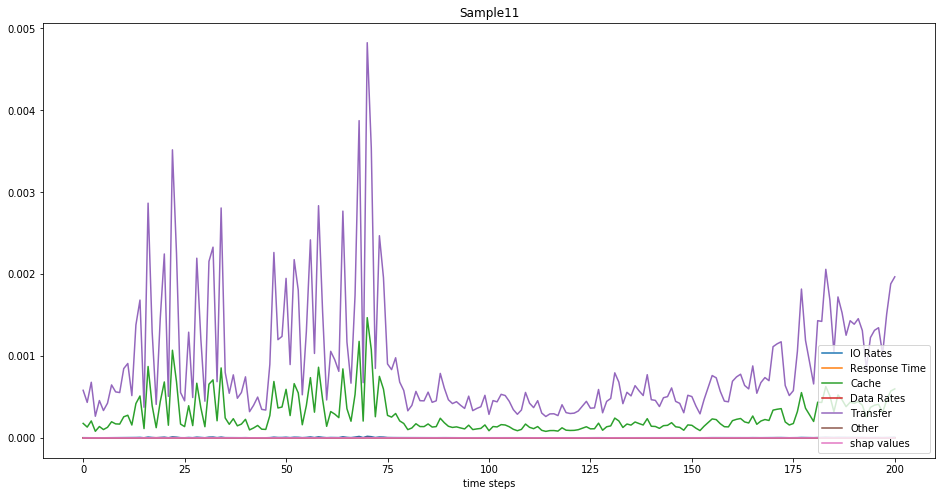

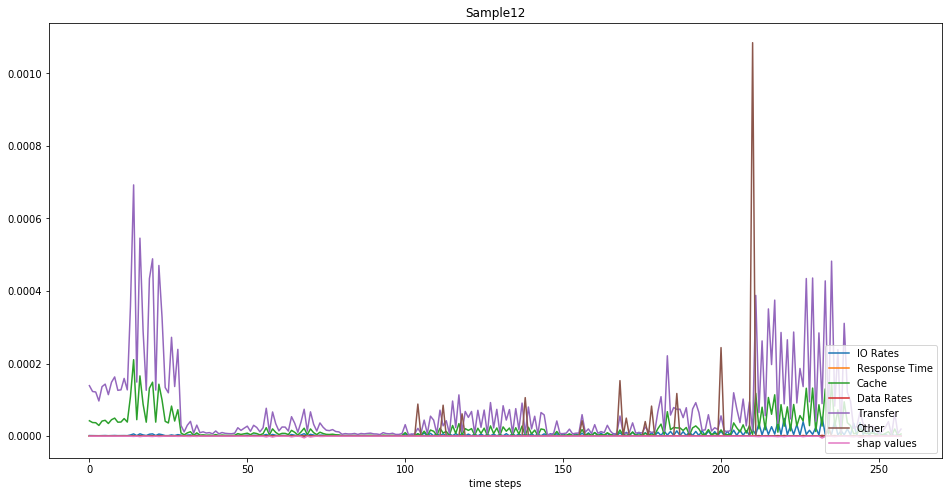

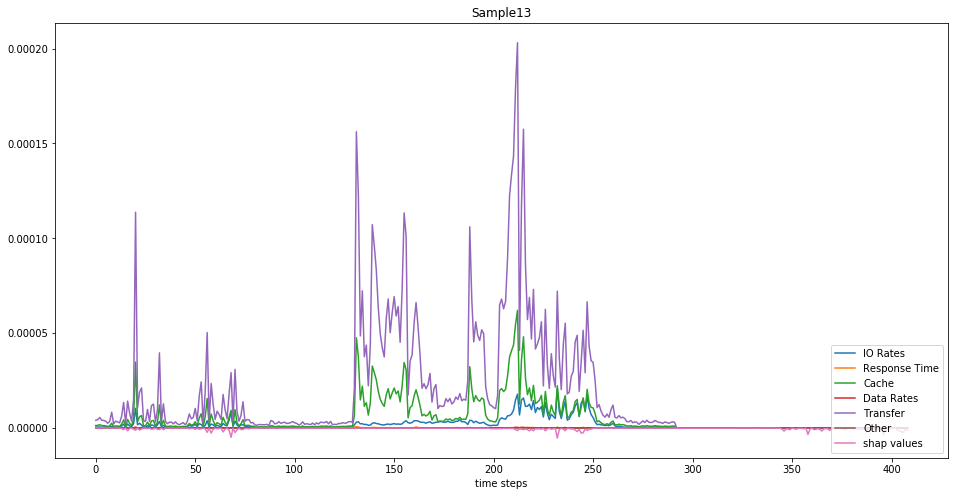

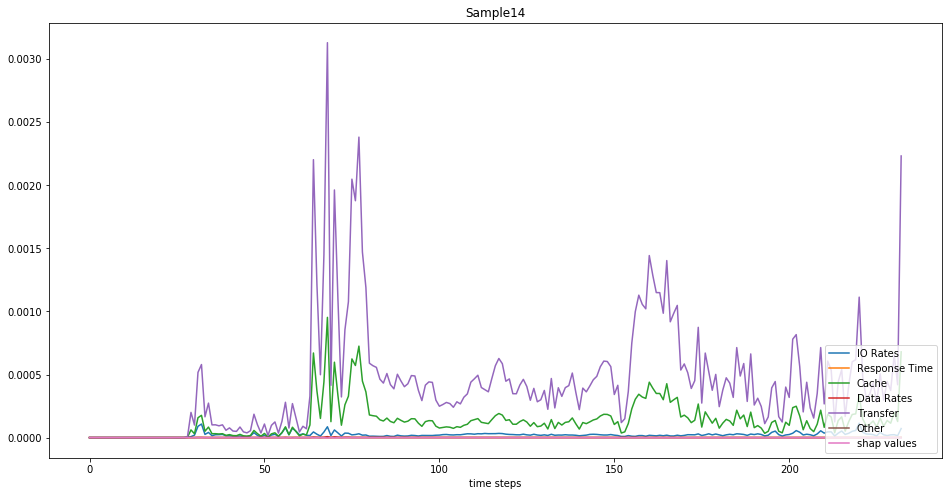

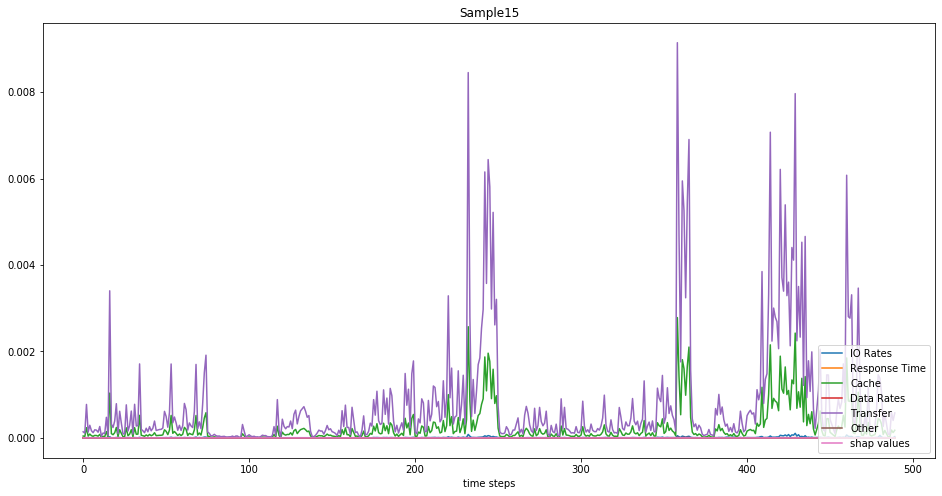

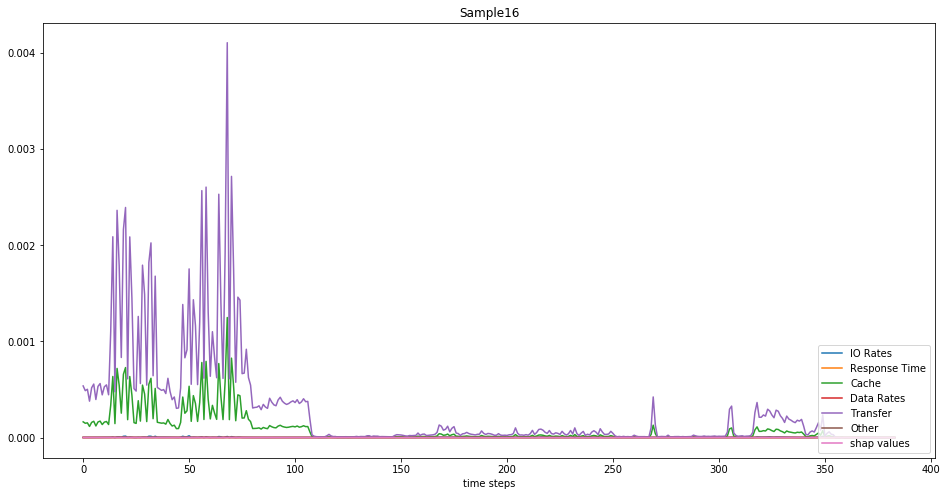

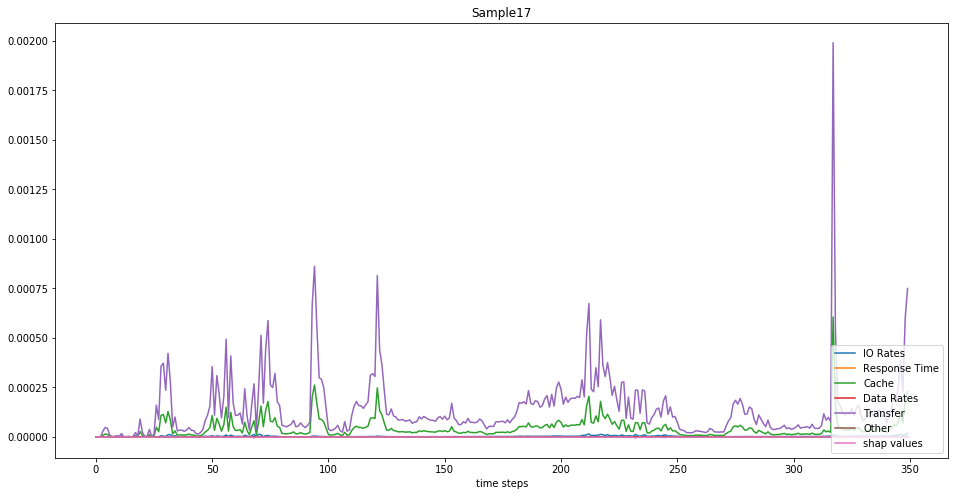

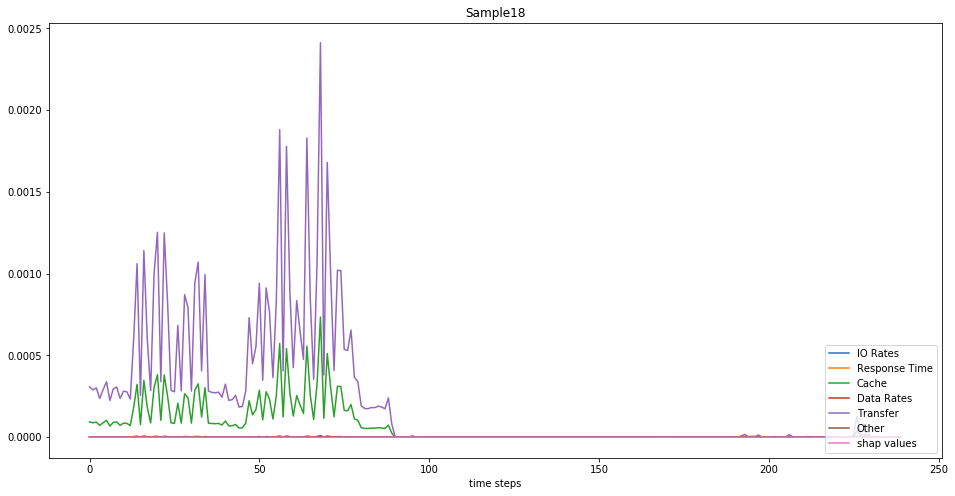

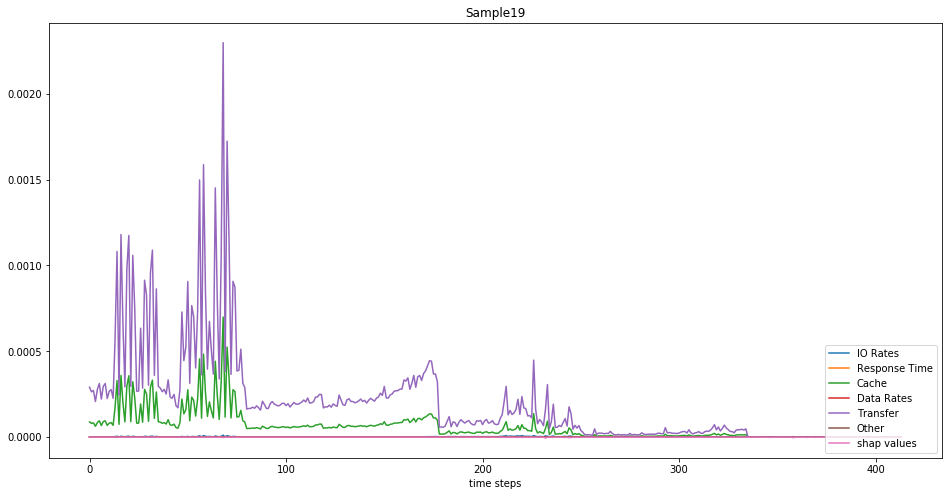

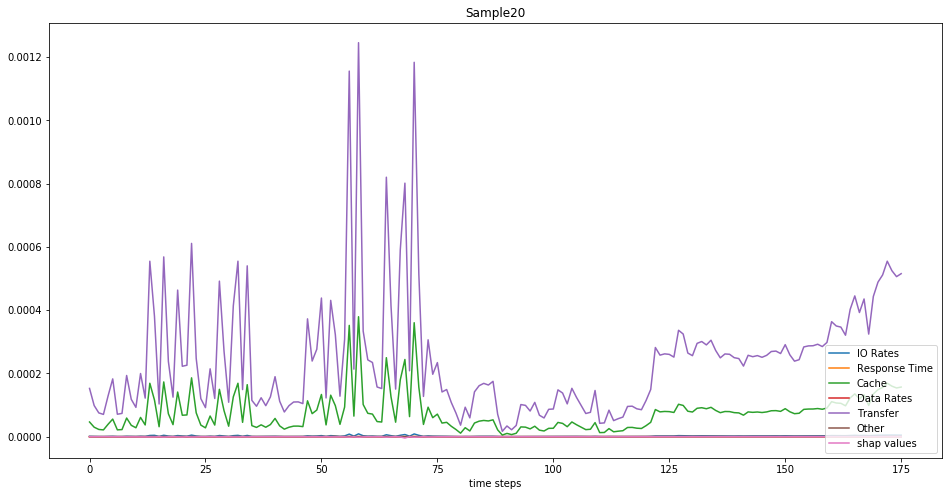

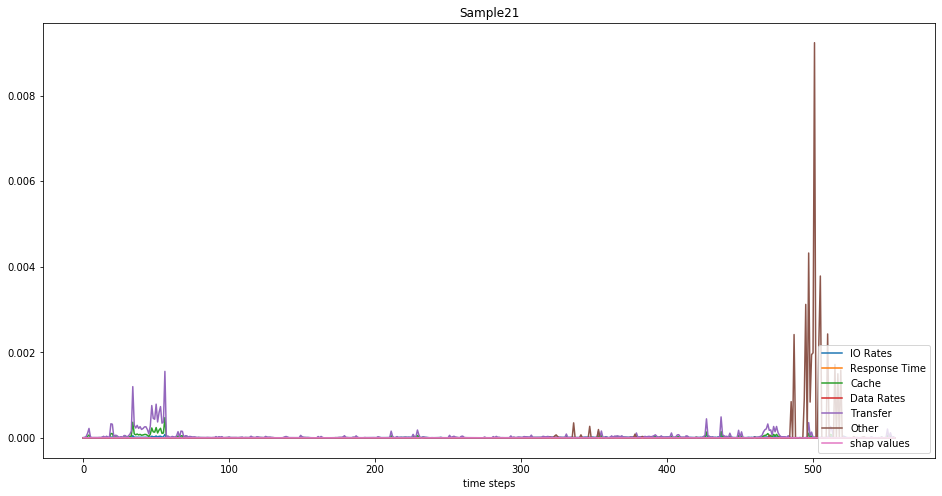

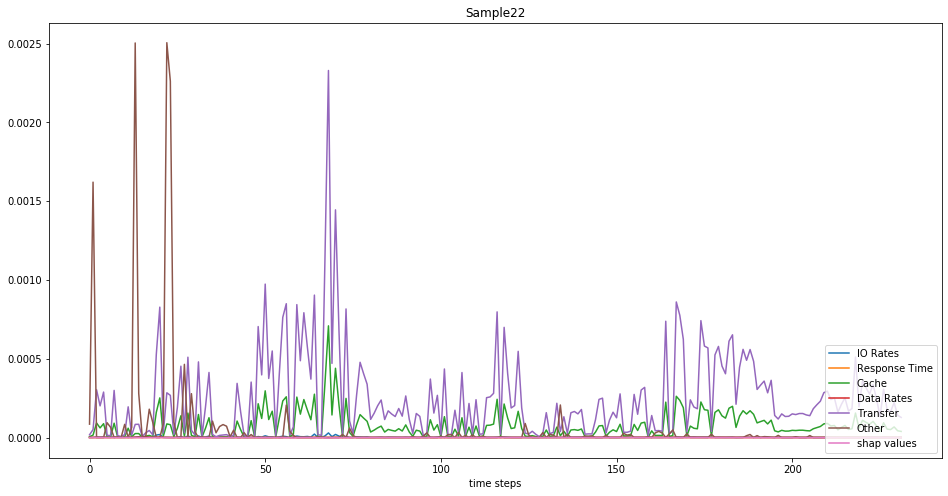

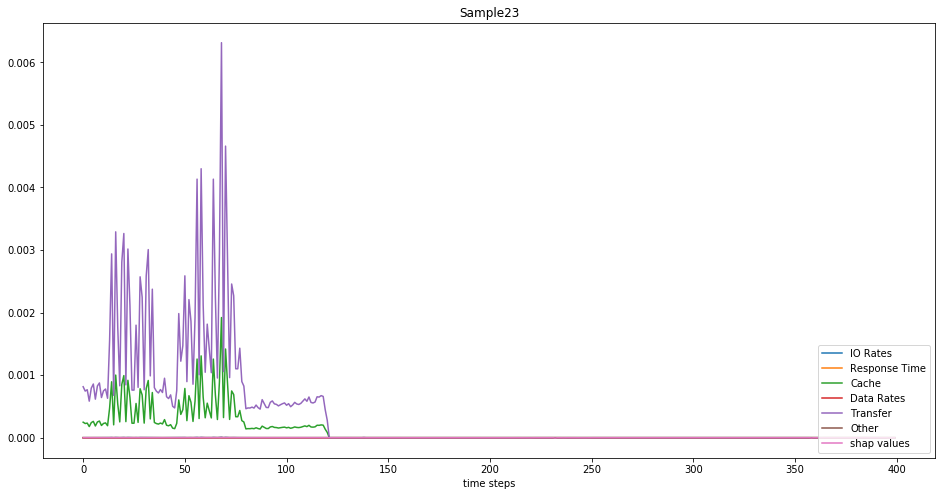

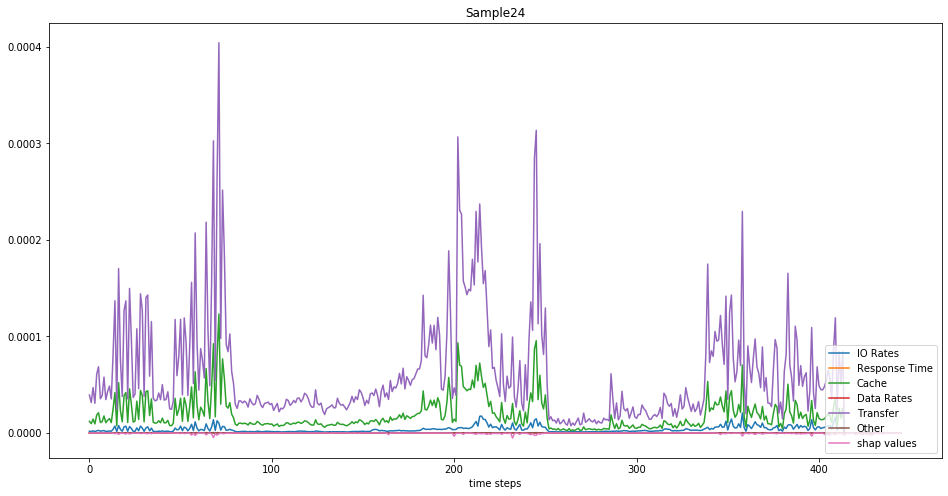

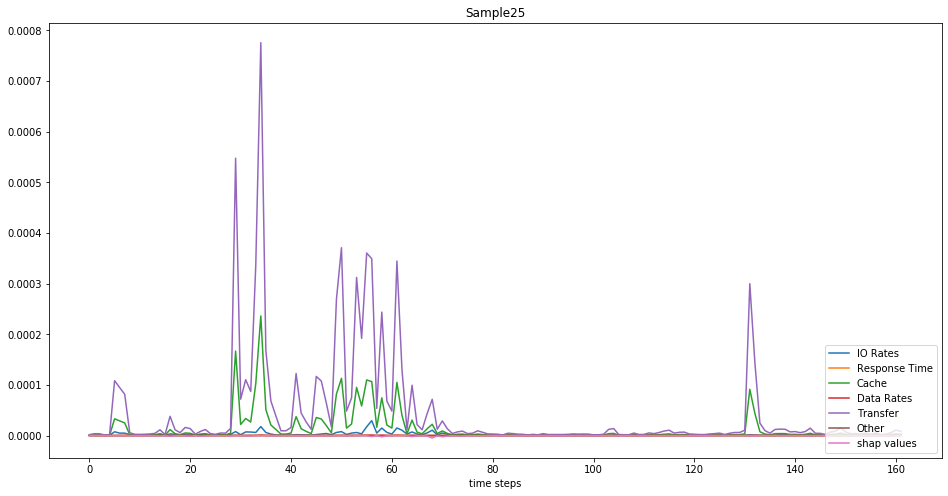

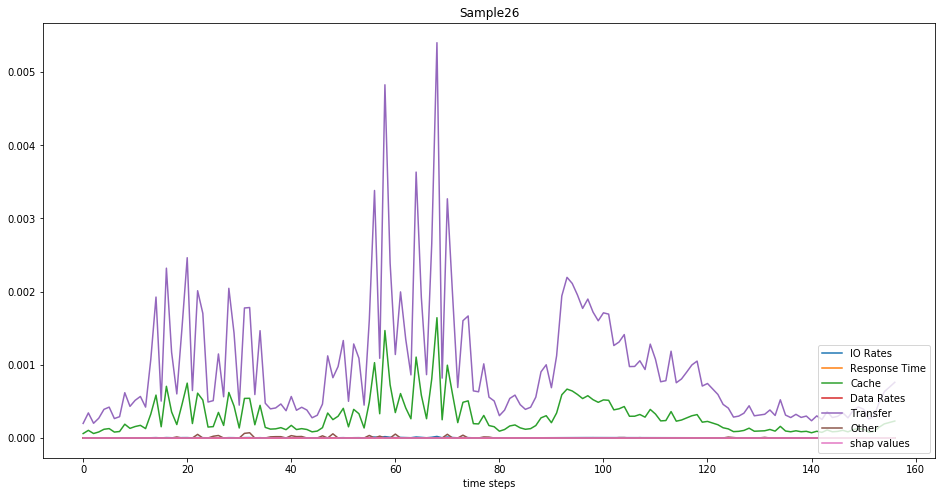

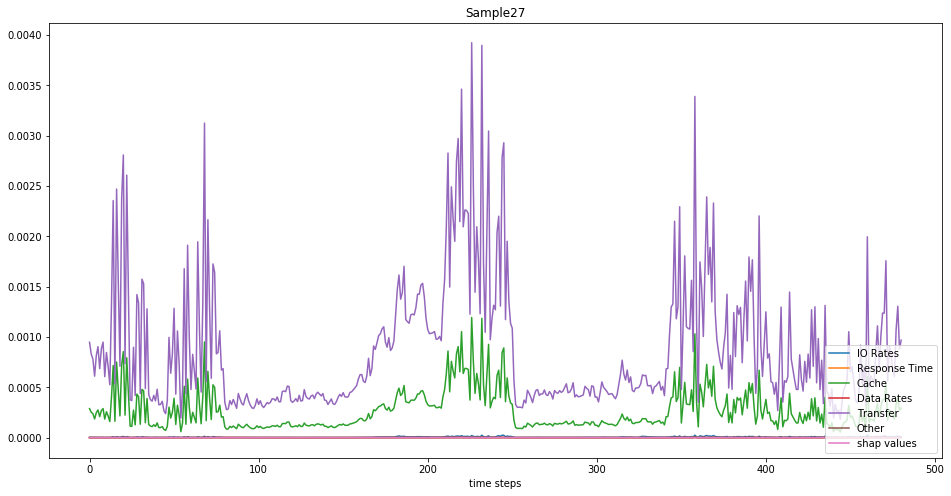

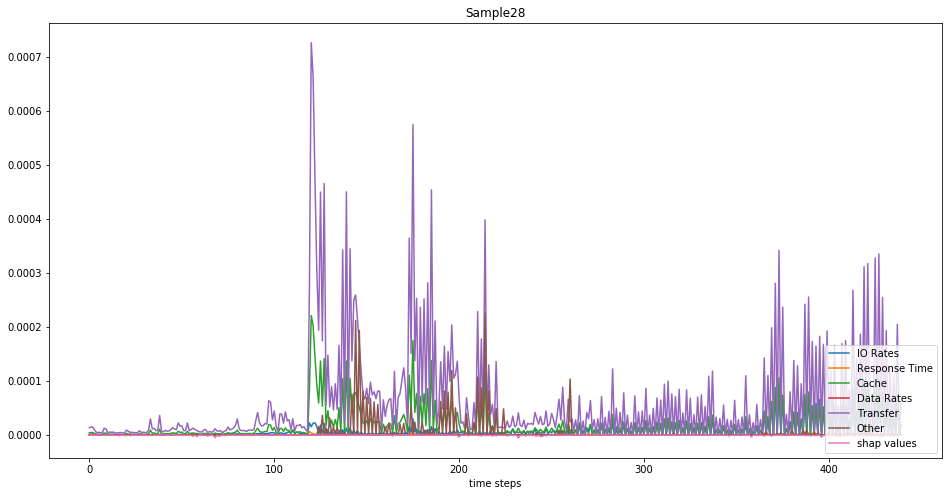

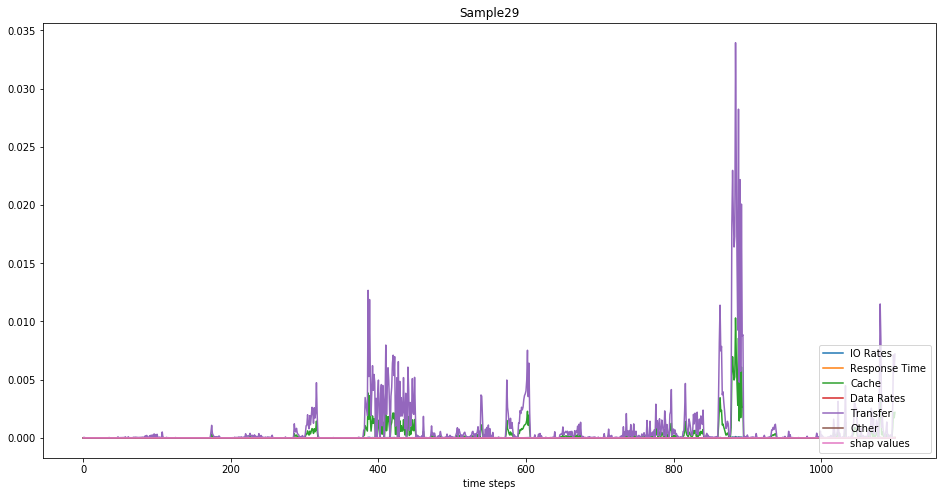

In [77]:
import matplotlib.pyplot as plt
for i in range(0,number_samples):
    plt.figure(figsize=(16,8))
    
    plt.plot(io_rate_data[i], label="IO Rates")
    plt.plot(response_rate_data[i], label="Response Time")
    plt.plot(cache_data[i], label="Cache")
    plt.plot(data_rates_data[i], label="Data Rates")
    plt.plot(transfer_data[i], label="Transfer")
    plt.plot(other_data[i], label="Other")
    
    plt.plot(shap_values_allFeatures[i], label="shap values")
    plt.xlabel("time steps")
    plt.legend(loc="lower right")
    plt.title("Sample"+str(i+1))

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


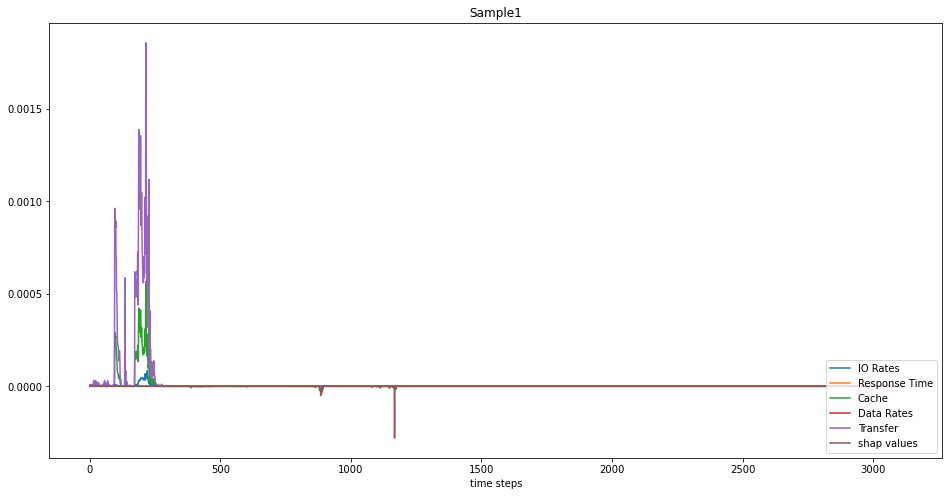

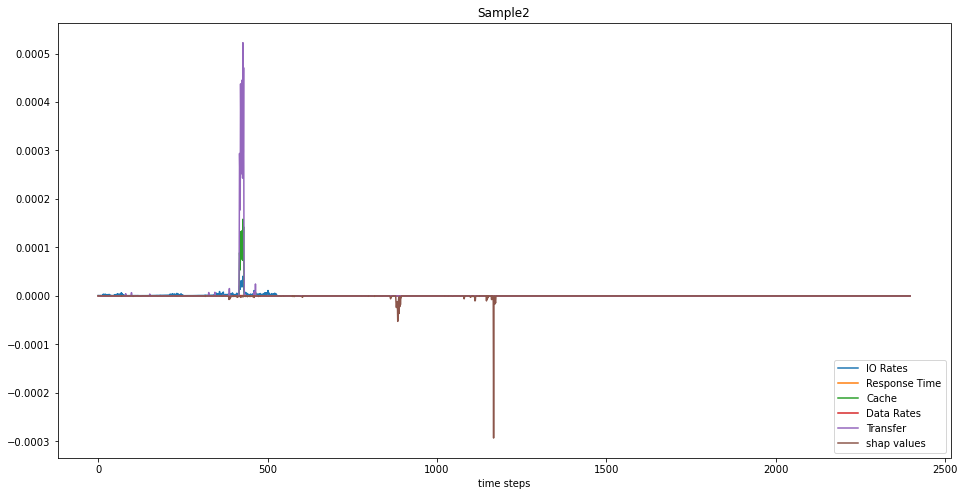

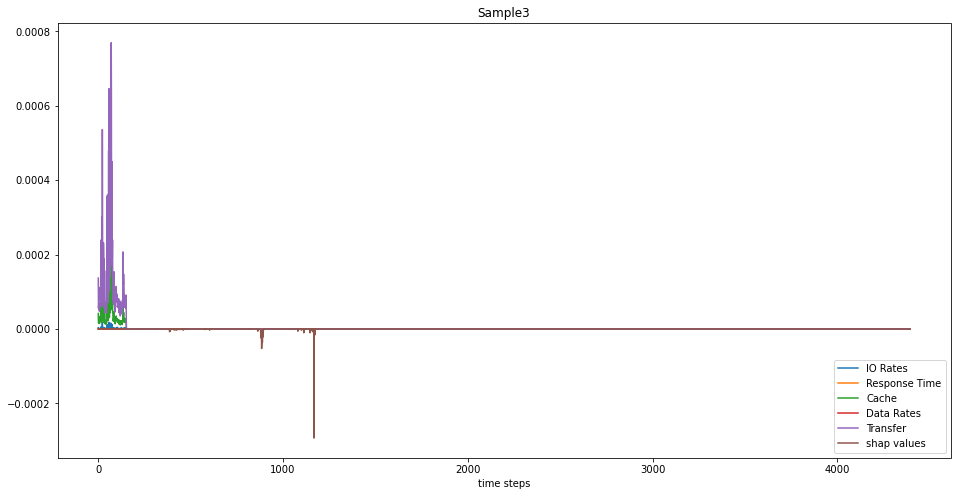

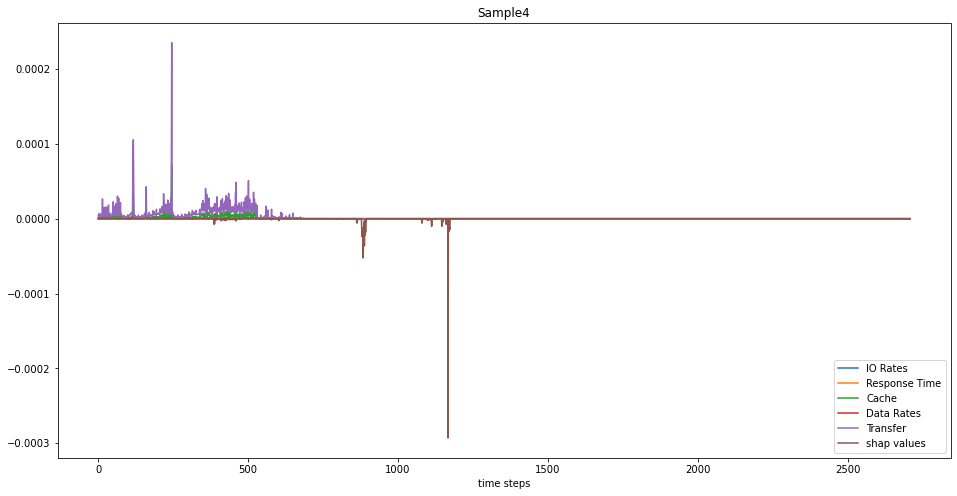

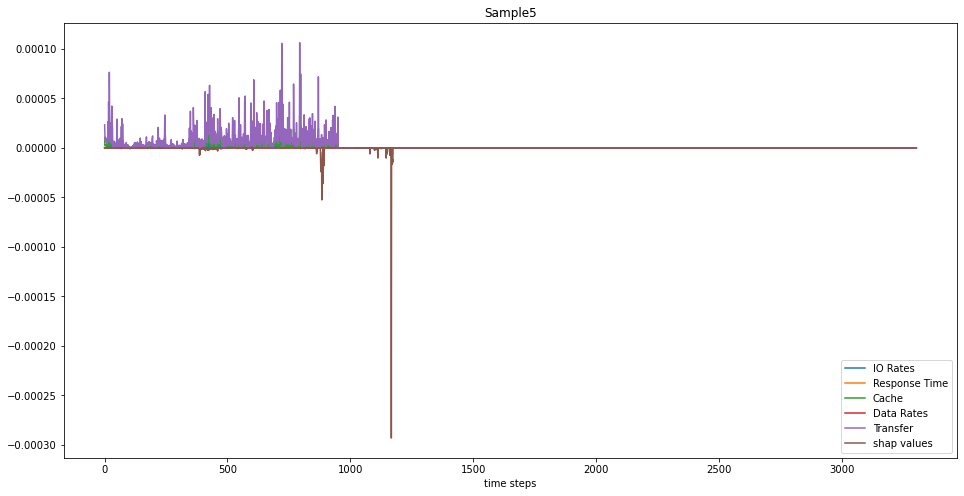

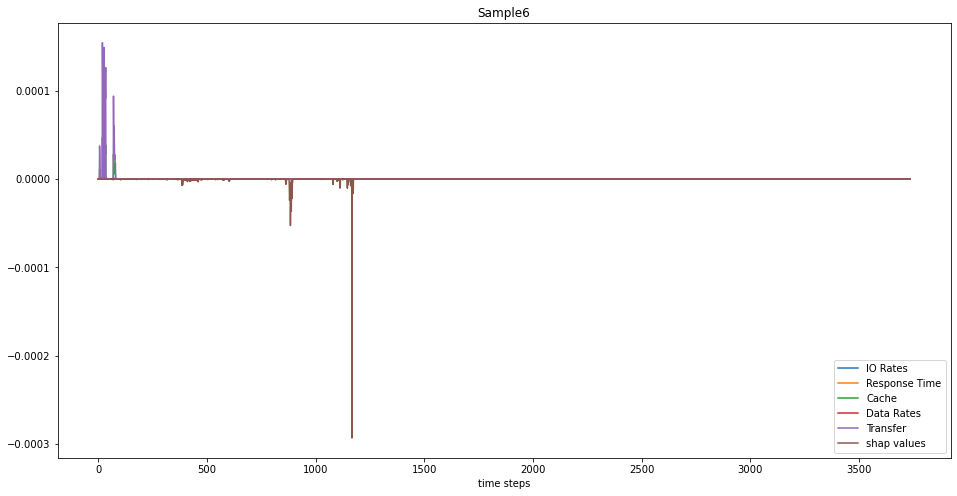

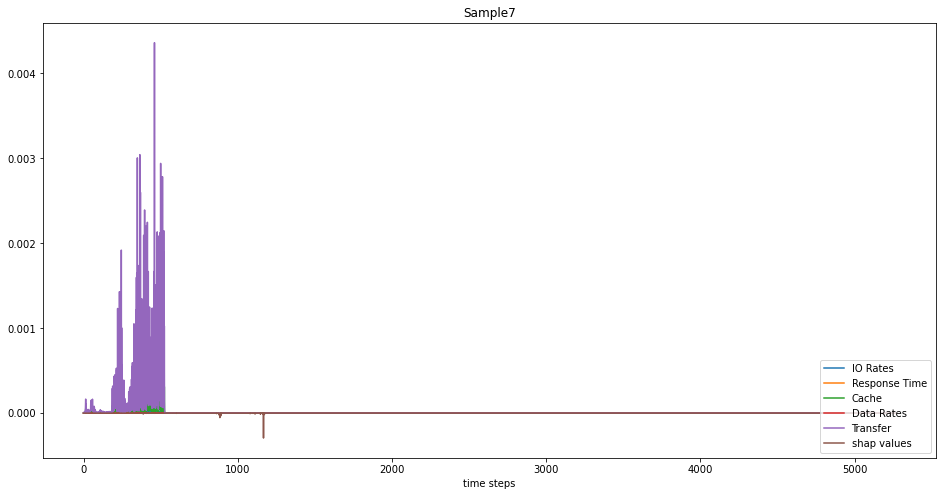

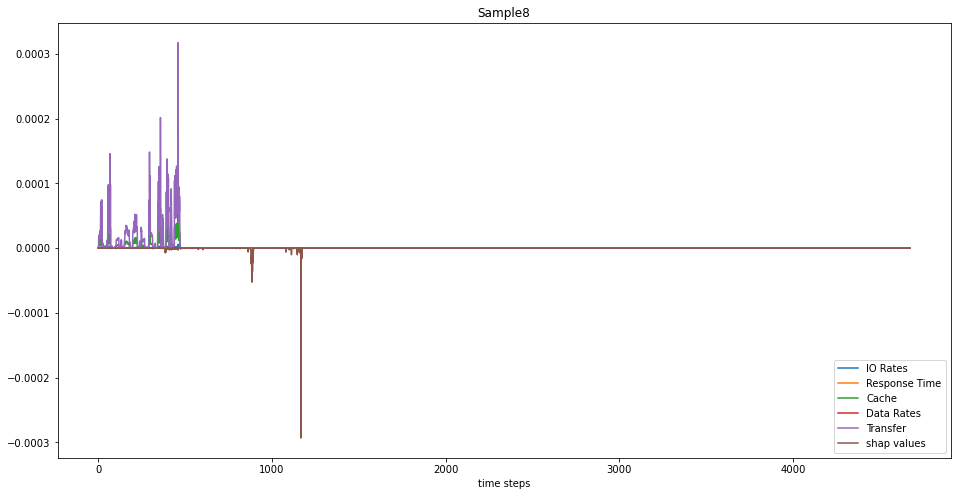

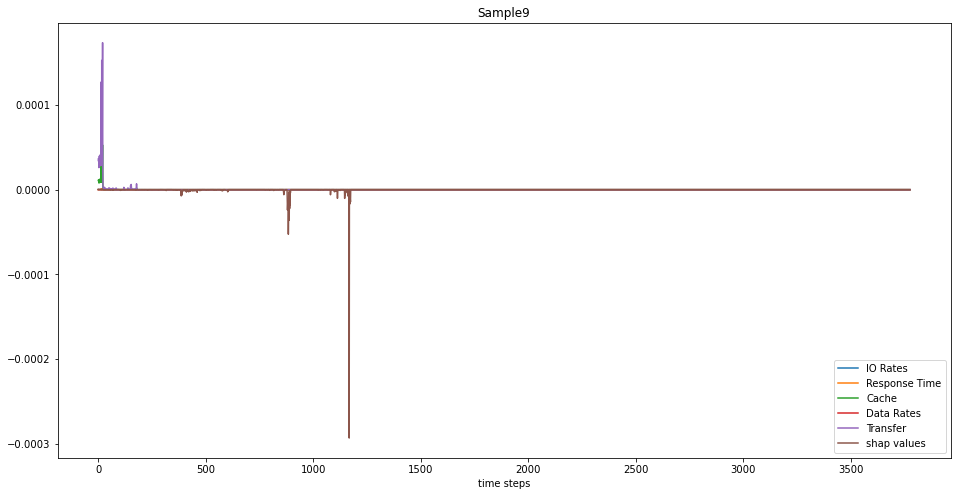

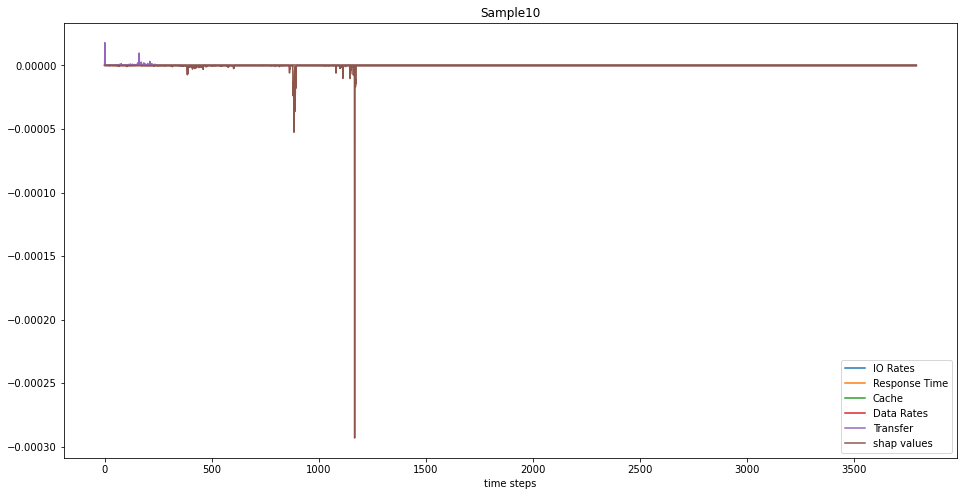

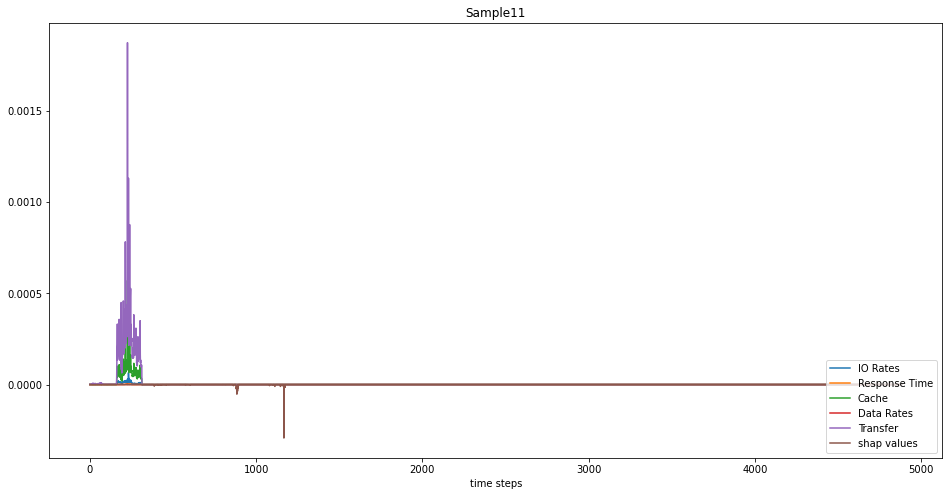

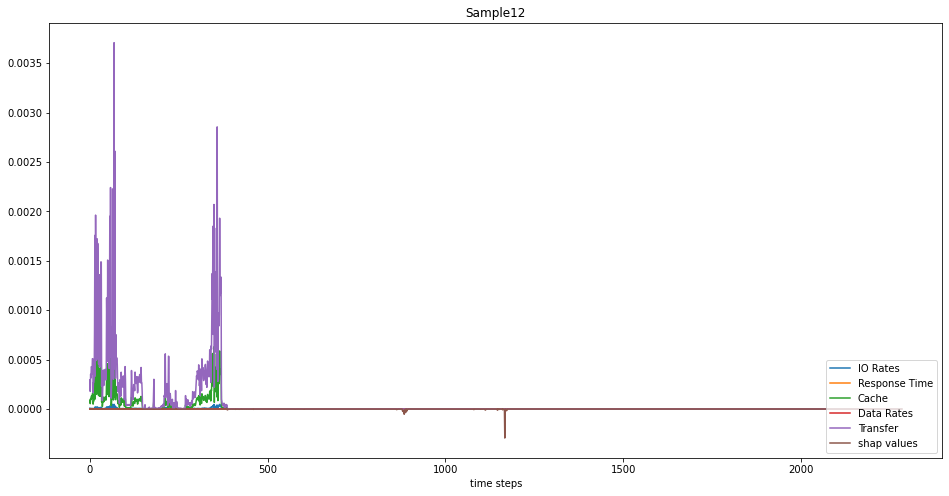

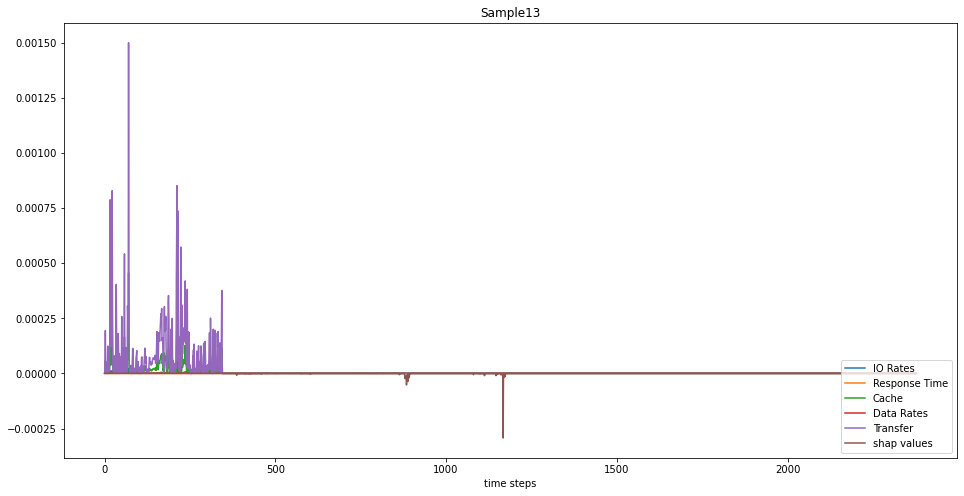

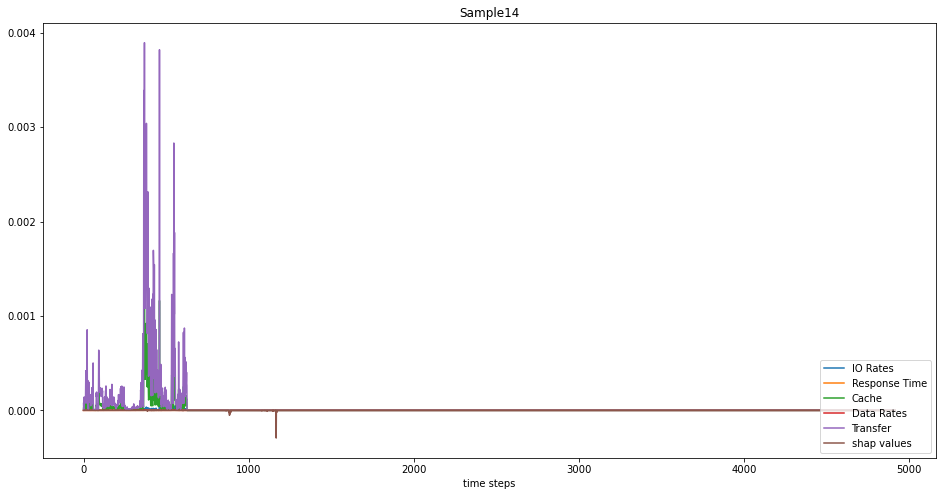

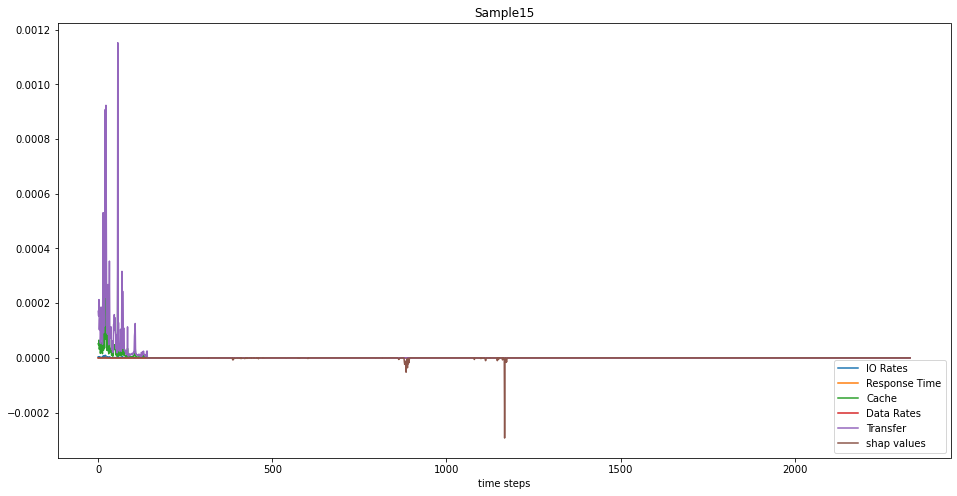

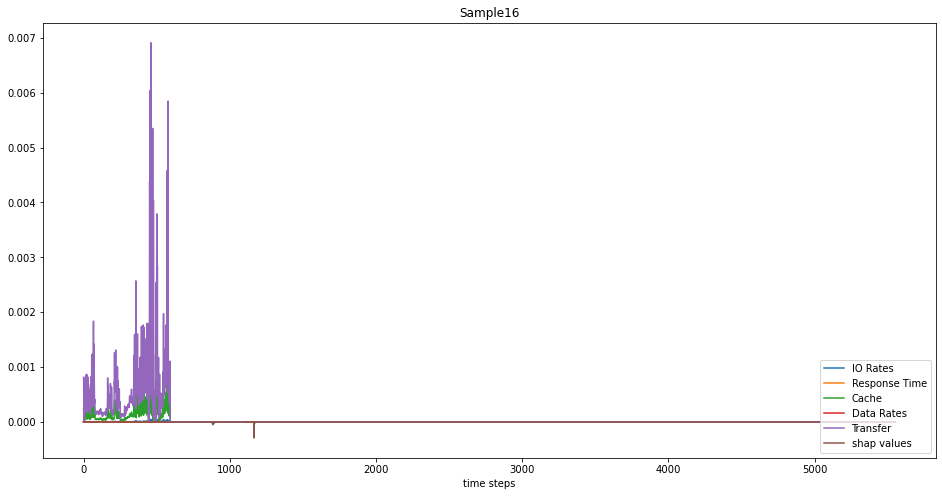

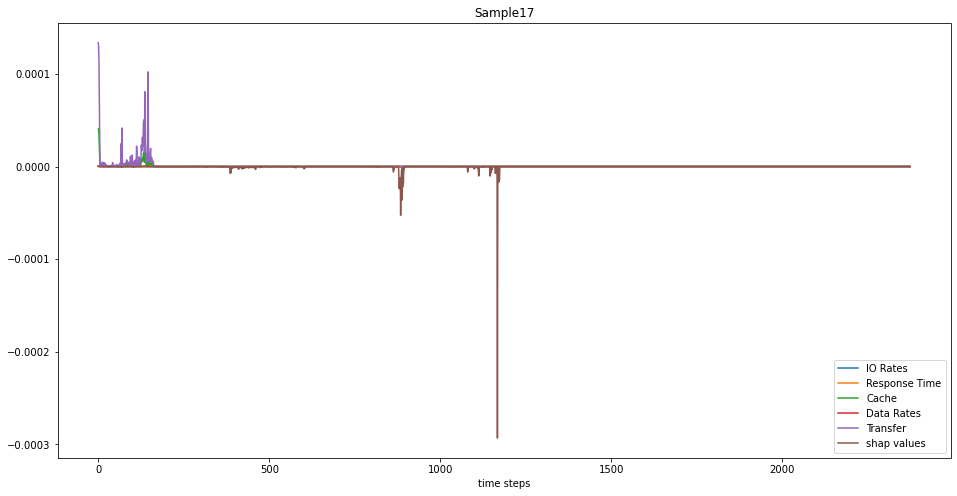

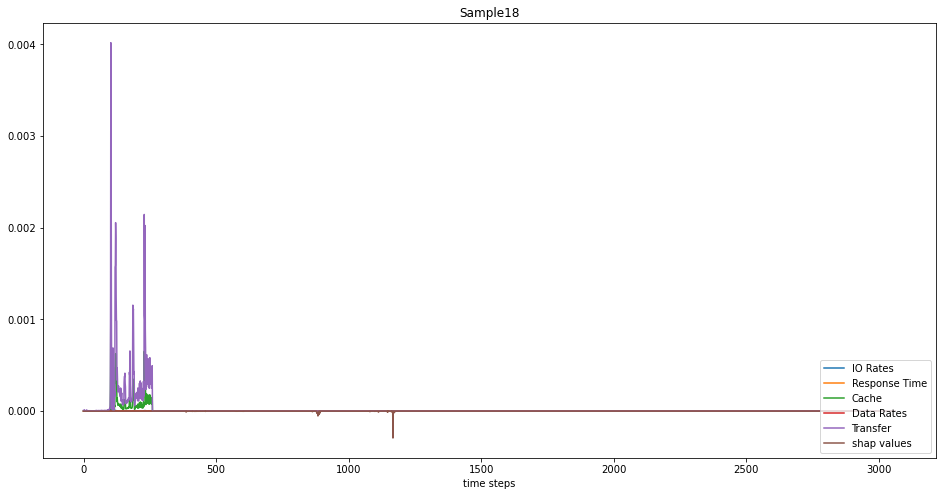

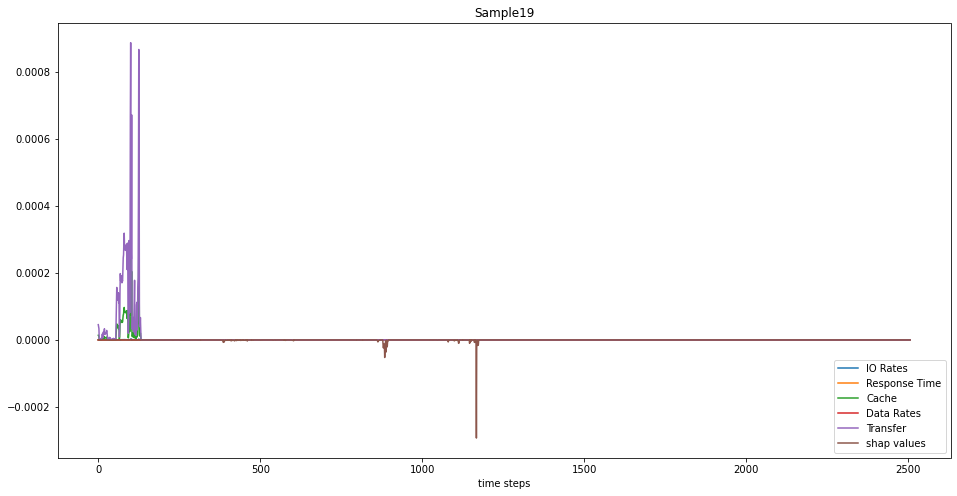

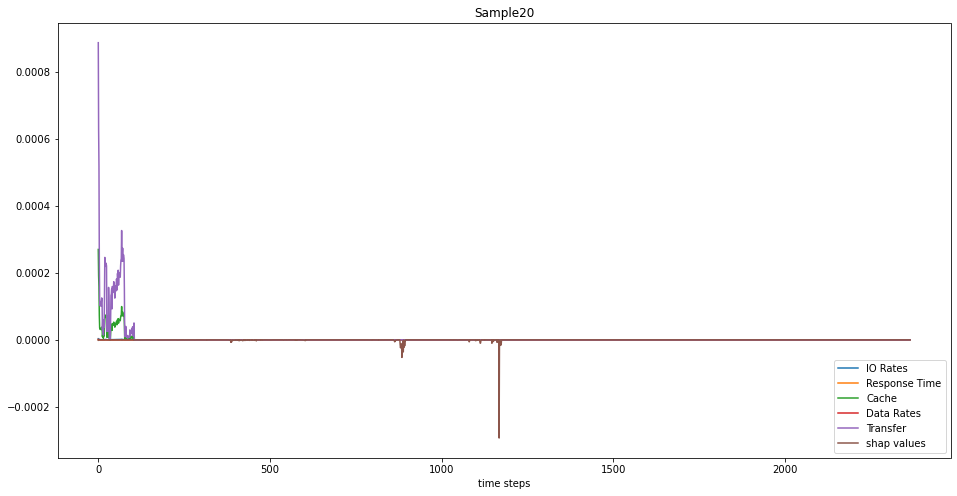

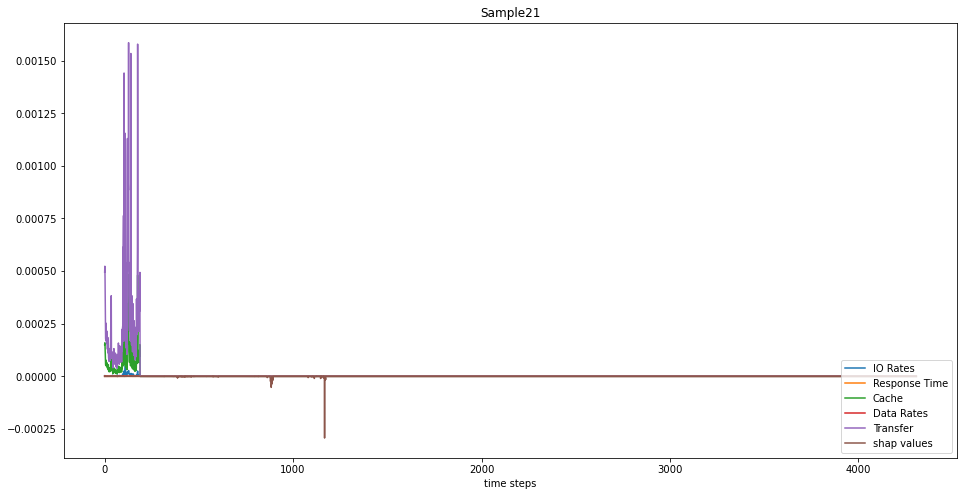

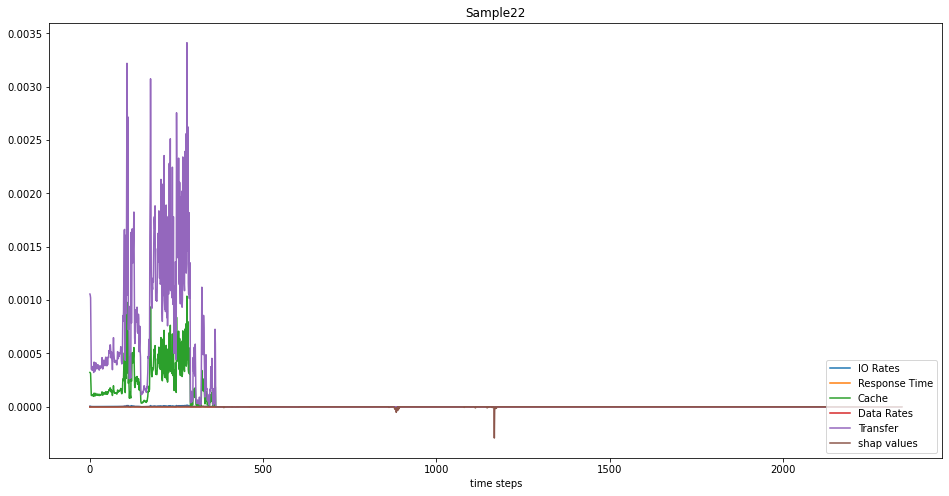

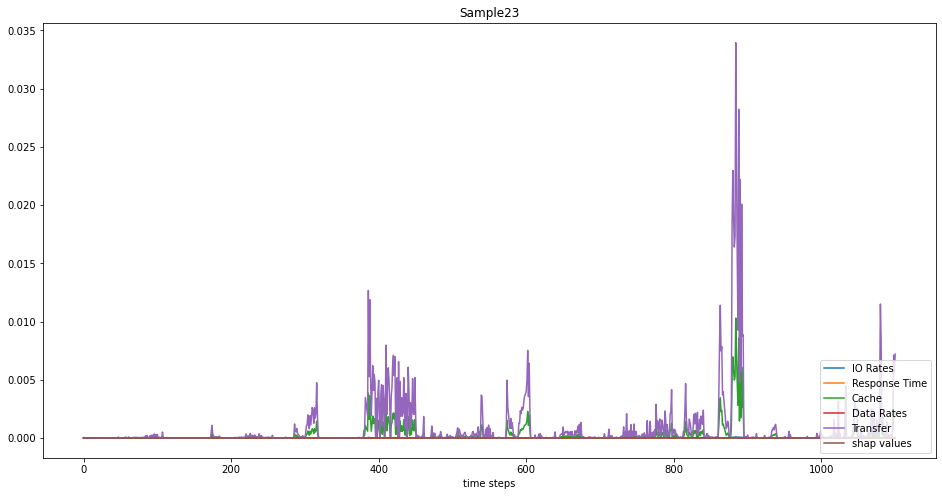

In [66]:
import matplotlib.pyplot as plt
for i in range(0,number_samples):
    plt.figure(figsize=(16,8))
    
    plt.plot(io_rate_data[i], label="IO Rates")
    plt.plot(response_rate_data[i], label="Response Time")
    plt.plot(cache_data[i], label="Cache")
    plt.plot(data_rates_data[i], label="Data Rates")
    plt.plot(transfer_data[i], label="Transfer")
    #plt.plot(other_data[i], label="Other")
    
    plt.plot(shap_values_allFeatures[i], label="shap values")
    plt.xlabel("time steps")
    plt.legend(loc="lower right")
    plt.title("Sample"+str(i+1))